---

title: **Interpolation Comparison** (*v 1.0*)

**Methods**:

- 1. [Shape-based interpolation](https://www.researchgate.net/publication/221400411_Efficient_Semiautomatic_Segmentation_of_3D_Objects_in_Medical_Images) inspired by Schenk *et al*.

- 2. [*Pyspatiotemporalgeom*](https://dl.acm.org/doi/10.1145/2996913.2996973) library based interpolation 

- 3. Conditional CNN-VAE interpolation

---

In [13]:
from watermark import watermark
print(watermark(author="\033[1m" +"Tiago F. R. Ribeiro" + "\033[0m", 
                github_username="\033[1m" +"Tiago1Ribeiro"+ "\033[0m", 
                current_date=True, current_time=True, python=True, updated=True,
                iversions=True,  globals_= globals()))

Author: Tiago F. R. Ribeiro

Github username: Tiago1Ribeiro

Last updated: 2023-04-12 15:06:53

Python implementation: CPython
Python version       : 3.10.9
IPython version      : 8.11.0

matplotlib: 3.7.1
numpy     : 1.24.2



In [162]:
### Notes...
### Metrics to compare interpolations
# - a) Root Mean Squared Error (RMSE)
# - b) Mean Absolute Error (MAE)
# - c) Mean Intersection over Union (MIoU)
# - d) Mean Hausdorff distance
# - e) IMPROVE TEMPORAL CONSISTENCY

### Libraries

In [132]:
import os   
import cv2                                          
import numpy as np                                                  
import math                                         
from glob import glob                              
from PIL import Image                              
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','no-latex'])
plt.style.use(['nature','no-latex'])
from shapely import wkt              
from shapely.geometry import Polygon, MultiPolygon, shape
from shapely.affinity import scale
from rasterio.features import shapes  
from rasterio import Affine           
from shapely.wkt import loads
from shapely import hausdorff_distance
# from shapely.geometry.base import geom_factory
# from shapely.geos import lgeos
from shapely.validation import make_valid
import geopandas as gpd

### Data sources

In [15]:
DIR = os.getcwd()
# Reference U-Net Based Segmentations
UNET_DIR = os.path.join("E:\BurnedAreaUAV_files\Results")
UNET_PNG_DIR = os.path.join(UNET_DIR, "segs_base")
UNET_WKT_FILE = os.path.join(UNET_DIR, "WKT_files\segs_unet_base.wkt")
# Test Segmentation from BurnedAreaUAV dataset
BA_UAV_DIR = os.path.normpath("E://BurnedAreaUAV_files//BurnedAreaUAV_dataset")
BA_UAV_WKT = os.path.join(BA_UAV_DIR, "WKT_files//test.wkt")
# Interpolation Directory
INTERPOL_DIR = os.path.normpath("E://BurnedAreaUAV_files//Interpolation")
# Sampled Masks
SAMPLED_MASKS = os.path.join(INTERPOL_DIR, "reference_masks//sampled_masks.txt")
# Shape Based Interpolations
SHP_DIR = os.path.join(INTERPOL_DIR, "shape_interpol")
SHP_PNG_DIR = os.path.join(SHP_DIR, "PNGs")
SHP_PNG_DIR_SAMPLED = os.path.join(SHP_DIR, "PNGs_sampled")
SHP_WKT_FILE = os.path.join(SHP_DIR, "shape_interpol.wkt")
SHP_WKT_FILE_SAMPLED = os.path.join(SHP_DIR, "shape_interpol_sampled.wkt")
# Pyspatiotemporalgeom interpolations
PSTG_DIR = os.path.join(INTERPOL_DIR, "pyspatiotemporalgeom_interpol")
PSTG_PNG_DIR = os.path.join(PSTG_DIR, "PNGs")
PSTG_PNG_DIR_SAMPLED = os.path.join(PSTG_DIR, "PNGs_sampled")
PSTG_WKT_FILE = os.path.join(PSTG_DIR, "pyspatial_interpol.wkt")
PSTG_WKT_FILE_SAMPLED = os.path.join(PSTG_DIR, "pyspatial_interpol_sampled.wkt")
# Convolutional VAE interpolations (DESATUALIZADO)
CVAE_DIR = os.path.join(INTERPOL_DIR, "cvae_interpol")
CVAE_PNG_DIR = os.path.join(CVAE_DIR, "PNGs")
CVAE_PNG_DIR_SAMPLED = os.path.join(CVAE_DIR, "PNGs_sampled")
CVAE_WKT_FILE = os.path.join(CVAE_DIR, "cvae_interpol.wkt")
CVAE_WKT_FILE_SAMPLED = os.path.join(CVAE_DIR, "cvae_interpol_sampled.wkt")

In [16]:
# extract indexes from SAMPLED_MASKS file
idx_sampled = []
with open(SAMPLED_MASKS, 'r') as f:
    for line in f:
        # for each line, extract number before the comma
        idx_sampled.append(int(line.split(',')[0]))
# multiply every element of idx_sampled by 100
idx_sampled = [i*100 for i in idx_sampled]
print("Sampled indexes: ", idx_sampled)

Sampled indexes:  [0, 1900, 2800, 4800, 5600, 7400, 8200, 8700, 10600, 12800, 17300, 19500, 22500]


### Configs

In [17]:
IMG_ORIG_DIMS = (720, 1280)
# default number of polygons
NUM_POLYGONS = 22500

### Auxiliary functions

rmse

In [167]:
# def rmse(wkt_true, wkt_pred):
#     """
#     Calcula o Root Mean Squared Error (RMSE) entre dois polígonos de segmentação
#     no formato WKT.
    
#     """
#     poly_true = shapely.wkt.loads(wkt_true)
#     poly_pred = shapely.wkt.loads(wkt_pred)

#     # Extrai as coordenadas x e y dos vértices dos polígonos
#     x_true, y_true = poly_true.exterior.coords.xy
#     x_pred, y_pred = poly_pred.exterior.coords.xy

#     # Calcula as diferenças quadráticas entre as coordenadas x e y 
#     # dos vértices dos polígonos
#     diff_x = np.subtract(x_true, x_pred)
#     diff_y = np.subtract(y_true, y_pred)
#     squared_diff_x = np.square(diff_x)
#     squared_diff_y = np.square(diff_y)

#     # Calcula a raiz quadrada da média das diferenças quadráticas
#     mean_squared_diff = np.mean(squared_diff_x) + np.mean(squared_diff_y)
#     rmse = math.sqrt(mean_squared_diff)

#     return rmse

make_valid

In [177]:
# def make_valid_func(ob):
#     """
#     Validates a polygon and returns a valid polygon.
#     """
#     if ob.is_valid:
#         return ob

#     return geom_factory(lgeos.GEOSMakeValid(ob._geom))

iou_wkt

In [22]:
def iou_wkt(ground_truth_file, model_file, num_polygons=NUM_POLYGONS, discard_100=False):
    """
    Calculates the Intersection over Union (IoU) between segmentation polygons
    in WKT format.

    Parameters
    ----------
    ground_truth_file : str
        Path to the ground truth WKT file.
    model_file : str
        Path to the model WKT file.
    num_polygons : int, optional
        Number of polygons to be used in the calculation.
    
    """
    # Read WKTS files
    print("Reading WKTs files...")
    with open(ground_truth_file, "r") as f:
        ground_truth_wkt = f.read().splitlines()
        
    with open(model_file, "r") as f:
        model_wkt = f.read().splitlines()

    # read WKTS file lines and convert to list of shapely polygons
    ground_truth_polys = [loads(wkt) for wkt in ground_truth_wkt]
    model_polys = [loads(wkt) for wkt in model_wkt]
    g_t_polys = ground_truth_polys[:num_polygons]
    model_polys = model_polys[:num_polygons]

    if discard_100:
        # discard polygons which index number is multiple of 100 (0, 100, 200, 300, etc)
        g_t_polys = [g_t_polys[i] for i in range(len(g_t_polys)) if i % 100 != 0]
        model_polys = [model_polys[i] for i in range(len(model_polys)) if i % 100 != 0]

    iou_list = list()
    print("Calculating IoU...")
    for i in range(len(g_t_polys)):
        g_t_polys[i]=  make_valid(g_t_polys[i])
        model_polys[i] = make_valid(model_polys[i])
        intersection = g_t_polys[i].intersection(model_polys[i]).area
        union = g_t_polys[i].union(model_polys[i]).area
        # Calculate the IoU
        iou = intersection / union
        iou_list.append(iou)    

    # Calculate the mean IoU
    iou_mean = np.mean(iou_list)
    # iou_mean = sum(iou_list) / len(iou_list)

    return iou_mean, iou_list

temporal_consistency v1

In [23]:
def temporal_consistency(wkt_file, num_polygons):
    """
    Calculates the temporal consistency between segmentation polygons in 
    WKT format.

    Parameters
    ----------
    wkt_file : str
        Path to the WKT file.
    num_polygons : int
        Number of polygons to be used in the calculation.
        
    Returns
    -------
    t_c_mean : float
        Mean temporal consistency.
    t_c_list : list
        List of temporal consistency values.    
    """

    print("Reading WKTs file...")
    with open(wkt_file, "r") as f:
        model_wkt = f.read().splitlines()

    # read WKTS file lines and convert to list of shapely polygons
    model_polys = [loads(wkt) for wkt in model_wkt]
    model_polys = model_polys[:num_polygons]

    t_c_list = list()
    print("Calculating the temporal consistency...")
    for i in range(len(g_t_polys)-1):
        model_polys[i] = make_valid(model_polys[i])
        model_polys[i+1] = make_valid(model_polys[i+1])
        # calculates the temporal consistency between two consecutive polygons
        t_c = model_polys[i].difference(model_polys[i+1]).area / g_t_polys[i+1].area
        t_c_list.append(t_c)
    
    # Calcula a média 
    t_c_mean = sum(t_c_list) / len(t_c_list)

    return t_c_mean, t_c_list

strided_temporal_consistency

In [166]:
def strided_temporal_consistency(polygons, num_polygons, stride=1, exp = True):
    """
    Calculates the temporal consistency between polygons in a sequence with a 
    certain stride.

    Args:
        model_polys (list): A list of Shapely Polygon objects representing the 
                            sequence of polygons.
        num_polygons (int): The total number of polygons in the sequence.
        stride (int, optional): The number of polygons to skip between 
                                comparisons. Defaults to 1.

    Returns:
        dict: A dictionary containing the temporal consistency values and 
              related information. The keys are:
            - i (list): A list of the starting indices of the compared polygon pairs.
            - strd (int): The stride value used.
            - tc (list): A list of the temporal consistency values calculated 
                         for each pair of polygons.
            - tc_mean (float): The mean temporal consistency value.
    """

    # Create empty dictionary to store the TC values and and indexes
    t_c = {key: [] for key in ["i", "strd", "tc", "tc_mean"]}

    # Make all polygons in the list valid before calculating temporal consistency
    polygons = [make_valid(poly) for poly in polygons]

    print(f"Calculating the temporal consistency with stride {stride}...")
    for i in range(0, num_polygons - stride, stride):
        # Calculates the temporal consistency between two consecutive polygons
        t_c["i"].append(i)
        tc_temp = 1 - (polygons[i].difference(polygons[i+stride]).area / polygons[i+stride].area)
        if exp: 
            t_c["tc"].append(np.power(tc_temp, 10))
        else:
            t_c["tc"].append(tc_temp)
    # print(t_c["tc"])
        
    # Calculates the mean of the temporal consistency
    t_c["tc_mean"] =  np.mean(t_c["tc"])
    t_c["strd"] = stride

    return t_c

Scaled Temporal Consistency plot

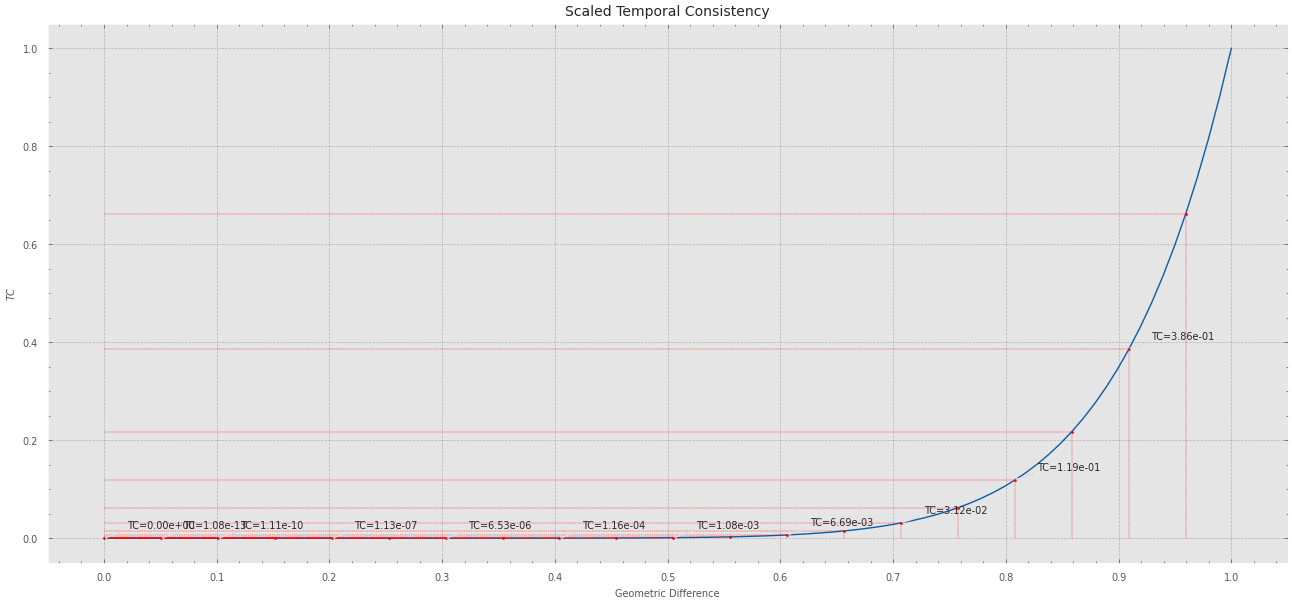

In [134]:
import numpy as np
import matplotlib.pyplot as plt

# figure size
plt.rcParams['figure.figsize'] = [16, 7]

geom_diff = np.linspace(0, 1, 100)

# Compute logarithmic scaling
def scale(x):
    return np.power(x, 10)

# Plot
fig, ax = plt.subplots()
ax.plot(geom_diff, scale(geom_diff))
ax.set_xlabel('Geometric Difference')
ax.set_ylabel('$TC$')
ax.set_title('Scaled Temporal Consistency')
# grid dashed line
ax.grid(color='grey', linestyle='--', linewidth=0.5, alpha=0.5)

# xticks
ax.set_xticks(np.arange(0, 1.1, 0.1))
# # yticks
# ax.set_yticks(np.arange(0, 1.1, 0.1))

# add labels and points for a few points
for i in range(0, 100, 5):
    ax.plot(geom_diff[i], scale(geom_diff[i]), 'ro', markersize=2)
    # add a line from the point to the x-axis
    ax.plot([geom_diff[i], geom_diff[i]], [0, scale(geom_diff[i])], 'r--', linewidth=0.3)
    # add a line from the point to the y-axis
    ax.plot([0, geom_diff[i]], [scale(geom_diff[i]), scale(geom_diff[i])], 'r--', linewidth=0.3)
    if i < 8 or i % 2 == 0:
        ax.annotate(f'TC={scale(geom_diff[i]):.2e}', 
                    xy=(geom_diff[i], scale(geom_diff[i])), 
                    xytext=(geom_diff[i]+0.02, scale(geom_diff[i])+0.02), 
                    arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=2, headlength=1))
                                     



In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# # figure size
# plt.rcParams['figure.figsize'] = [16, 7]
# plt.style.use('seaborn-whitegrid')


# # Sample geometric differece values
# # => worst case scenario: 1 (no overlap)
# # => best case scenario: 0  (perfect overlap)
# geom_diff = np.linspace(0, 1, 100)

# # Compute logarithmic scaling
# def scale(x):
#     return np.exp(-10*x)

# # Plot
# fig, ax = plt.subplots()
# ax.plot(geom_diff, scale(geom_diff))
# ax.set_xlabel('Geometric Difference')
# ax.set_ylabel('$TC$')
# ax.set_title('Scaled Temporal Consistency')
# # grid dashed line
# ax.grid(color='grey', linestyle='--', linewidth=0.5, alpha=0.5)

# # xticks
# ax.set_xticks(np.arange(0, 1.1, 0.1))
# # yticks
# ax.set_yticks(np.arange(0, 1.1, 0.1))

# # add labels and points for a few points
# for i in range(0, 100, 5):
#     ax.plot(geom_diff[i], scale(geom_diff[i]), 'ro', markersize=2)
#     # add a line from the point to the x-axis
#     ax.plot([geom_diff[i], geom_diff[i]], [0, scale(geom_diff[i])], 'r--', linewidth=0.3)
#     # add a line from the point to the y-axis
#     ax.plot([0, geom_diff[i]], [scale(geom_diff[i]), scale(geom_diff[i])], 'r--', linewidth=0.3)
#     # add labels with small arrow for the first 8 point and then every 2th point 
#     if i < 8 or i % 2 == 0:
#         ax.annotate(f'TC={scale(geom_diff[i]):.2e}', 
#                     xy=(geom_diff[i], scale(geom_diff[i])), 
#                     xytext=(geom_diff[i]+0.02, scale(geom_diff[i])+0.02), 
#                     arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=2, headlength=1))
                                     

# # add box, white background with the complete TC formula, including the math symbols and the exponent, LateX style, top right 
# ax.text(0.95, 0.95, r'$TC = \exp(-10 \cdot \frac{A_{diff}}{A_{union}})$', 
#        fontsize=13, horizontalalignment='right', verticalalignment='top', 
#        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'))
# plt.show()

hausdorff_dist_wkt

In [25]:
def hausdorff_dist_wkt(ground_truth_file, model_file, last_frame=22500, discard_100=False):
    """
    Calculates the Hausdorff distance between the ground truth and the model.

    Args:
        ground_truth_file (str): The path to the ground truth WKTS file.
        model_file (str): The path to the model WKTS file.
        last_frame (int, optional): The last frame to consider. Defaults to 22500.
        discard (bool, optional): Whether to discard polygons which index number 
        is multiple of 100 (0, 100, 200, 300, etc). Defaults to False.  

    Returns:
        dict: A dictionary containing the Hausdorff distance values and related 
        information. The keys are:
            - i (list): A list of the starting indices of the compared polygon
             pairs.
            - hd (list): A list of the Hausdorff distance values calculated for 
            each pair of polygons.
            - hd_mean (float): The mean Hausdorff distance value.

    """
    # Read WKTS files
    print("Reading WKTs files...")
    with open(ground_truth_file, "r") as f:
        ground_truth_wkt = f.read().splitlines()
        
    with open(model_file, "r") as f:
        model_wkt = f.read().splitlines()

    # read WKTS file lines and convert to list of shapely polygons
    ground_truth_polys = [loads(wkt) for wkt in ground_truth_wkt]
    model_polys = [loads(wkt) for wkt in model_wkt]

    g_t_polys = ground_truth_polys[:last_frame]
    model_polys = model_polys[:last_frame]

    if discard_100:
        # discard polygons which index number is multiple of 100 (0, 100, 200, 300, etc)
        g_t_polys = [g_t_polys[i] for i in range(len(g_t_polys)) if i % 100 != 0]
        model_polys = [model_polys[i] for i in range(len(model_polys)) if i % 100 != 0]

    hausdorff_dist_list = list()
    print("Calculating Hausdorf Distance...")
    for i in range(len(g_t_polys)):
        g_t_polys[i]=  make_valid(g_t_polys[i])
        model_polys[i] = make_valid(model_polys[i])
        # hausdorff_dist = loads(ground_truth_wkt[i]).hausdorff_distance(loads(model_polys[i]))
        hausdorff_dist = g_t_polys[i].hausdorff_distance(model_polys[i])
        hausdorff_dist_list.append(hausdorff_dist)    

    # Calcula a média dos valores de IoU
    hausdorff_dist_mean = sum(hausdorff_dist_list) / len(hausdorff_dist_list)

    return hausdorff_dist_mean, hausdorff_dist_list

# 0.25 Hz Interpolations

## Comparison with **UNET** generated segmentations

### IoU metric

In [27]:
iou_shp_pr, iou_list_shp_pr = iou_wkt(UNET_WKT_FILE, SHP_WKT_FILE, num_polygons=NUM_POLYGONS, discard_100=True)
iou_cvae_pr, iou_list_cvae_pr = iou_wkt(UNET_WKT_FILE, CVAE_WKT_FILE, num_polygons=NUM_POLYGONS, discard_100=True)
iou_pstg_pr, iou_list_pstg_pr = iou_wkt(UNET_WKT_FILE, PSTG_WKT_FILE, num_polygons=NUM_POLYGONS, discard_100=True)

Reading WKTs files...
Calculating IoU...
Reading WKTs files...
Calculating IoU...
Reading WKTs files...
Calculating IoU...


In [28]:
print(f"Shape based interpolation: meanIou {iou_shp_pr:.3f} \n")
print(f"Conditional VAE interpolation: meanIoU {iou_cvae_pr:.3f} \n")
print(f"Pyspatiotemporalgeom interpolation: meanIoU {iou_pstg_pr:.3f} \n")

Shape based interpolation: meanIou 0.744 

Conditional VAE interpolation: meanIoU 0.739 

Pyspatiotemporalgeom interpolation: meanIoU 0.703 



### Boxplots for the IoU 

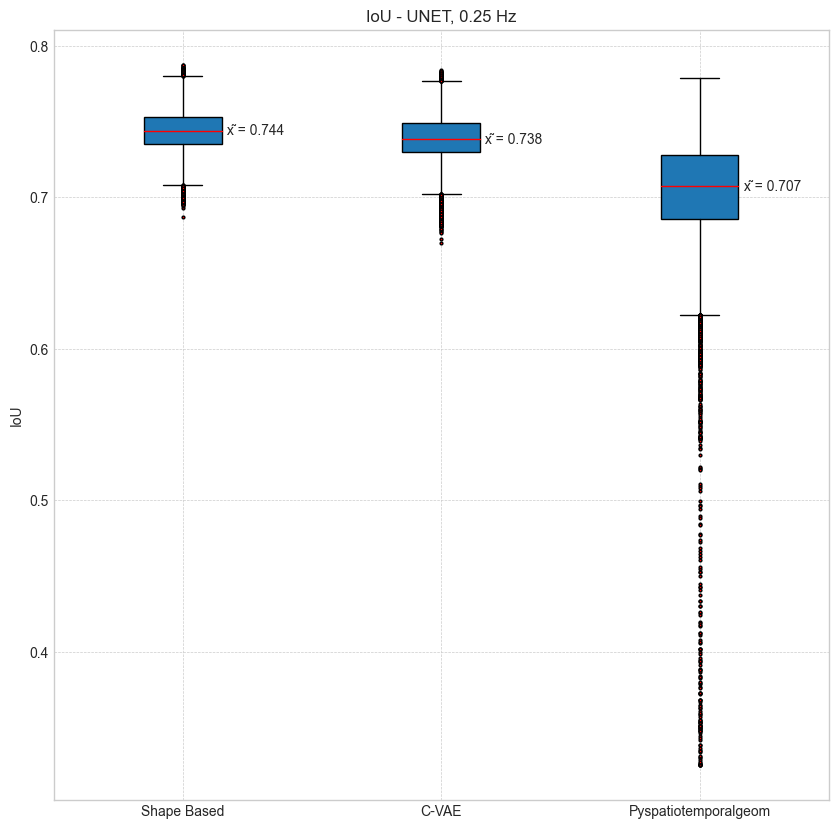

In [183]:
# Combine the data into a list
data = [iou_list_shp_pr, iou_list_cvae_pr, iou_list_pstg_pr]

fig, ax = plt.subplots(figsize=(10, 10))

boxplot = ax.boxplot(data, labels=['Shape Based', 'C-VAE', 'Pyspatiotemporalgeom'], 
                     medianprops={'linewidth': 1, 'color': 'red'},
                     flierprops=dict(markerfacecolor='r', markersize=2),
                     patch_artist=True)

# Add dashed gridlines
ax.grid(linestyle='--', linewidth=0.5)

# Add annotation for median values
for i, box in enumerate(boxplot['medians']):
    ax.annotate(f" x͂ = {box.get_ydata()[0]:.3f}", 
                xy=(i+1, box.get_ydata()[0]), 
                xytext=(29, 0),
                textcoords='offset points',
                va='center')
ax.set_ylabel('IoU')
ax.set_title('IoU - UNET, 0.25 Hz')

# Show the plot
plt.show();

### Hausdorf Distance

In [251]:
hd_shp_mean, hd_list_shp_pr = hausdorff_dist_wkt(UNET_WKT_FILE, SHP_WKT_FILE, last_frame=NUM_POLYGONS, discard_100=True)
hd_cvae_mean, hd_list_cvae_pr = hausdorff_dist_wkt(UNET_WKT_FILE, CVAE_WKT_FILE, last_frame=NUM_POLYGONS, discard_100=True)
hd_pstg_mean, hd_list_pstg_pr = hausdorff_dist_wkt(UNET_WKT_FILE, PSTG_WKT_FILE, last_frame=NUM_POLYGONS, discard_100=True)

Reading WKTs files...
Calculating Hausdorf Distance...
Reading WKTs files...
Calculating Hausdorf Distance...
Reading WKTs files...
Calculating Hausdorf Distance...


In [252]:
print(f"Shape based interpolation: mean Hausdorf Dist. {hd_shp_mean:.3f} \n")
print(f"Conditional VAE interpolation: mean Hausdorf Dist. {hd_cvae_mean:.3f} \n")
print(f"Pyspatiotemporalgeom interpolation: mean Hausdorf Dist. {hd_pstg_mean:.3f} \n")

Shape based interpolation: mean Hausdorf Dist. 229.439 

Conditional VAE interpolation: mean Hausdorf Dist. 230.883 

Pyspatiotemporalgeom interpolation: mean Hausdorf Dist. 232.565 



### Boxplots for Hausdord Distance

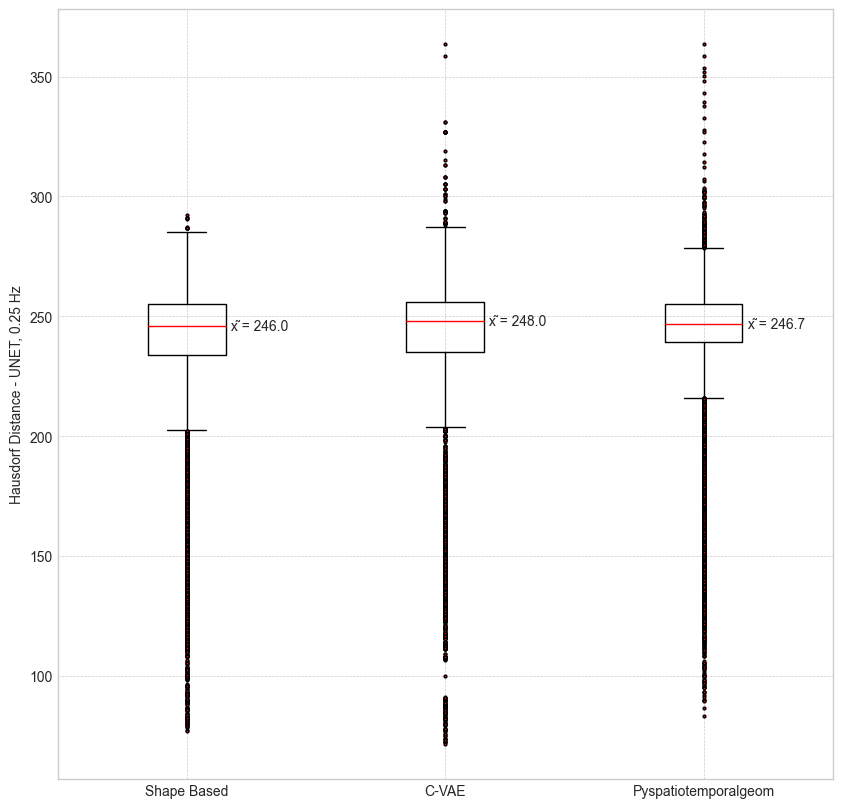

In [187]:
# Combine the data into a list
data = [hd_list_shp, hd_list_cvae, hd_list_pstg]

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 10))

# Create the boxplot with median annotation
boxplot = ax.boxplot(data, labels=['Shape Based', 'C-VAE', 'Pyspatiotemporalgeom'], 
                     medianprops={'linewidth': 1, 'color': 'red'},
                     flierprops=dict(markerfacecolor='r', markersize=2), 
                     patch_artist=False)

# Add dashed gridlines
ax.grid(linestyle='--', linewidth=0.5)

# # Add annotation for median values
for i, box in enumerate(boxplot['medians']):
    ax.annotate(f" x͂ = {box.get_ydata()[0]:.1f}", 
                xy=(i+1, box.get_ydata()[0]), 
                xytext=(29, 0),
                textcoords='offset points',
                va='center')
ax.set_ylabel('Hausdorf Distance - UNET, 0.25 Hz')

# Show the plot
plt.show()

## Comparison with the BurnedAreaUAV **Test set**

### Data preparation

In [239]:
# test set frame indexes 
idx = np.linspace(20250, 22450, 23).astype(int)  

# Read WKTS files
print("Reading WKTs files...")
with open(BA_UAV_WKT, "r") as f:
    test_wkt = f.read().splitlines()

with open(SHP_WKT_FILE, "r") as f:
    shp_wkt = f.read().splitlines()

with open(CVAE_WKT_FILE, "r") as f:
    cvae_wkt = f.read().splitlines()

with open(PSTG_WKT_FILE, "r") as f:
    pstg_wkt = f.read().splitlines()

print("Filtering WKTs files...")
shp_wkt = [shp_wkt[i] for i in idx]
cvae_wkt = [cvae_wkt[i] for i in idx]
pstg_wkt = [pstg_wkt[i] for i in idx]
# print the length of all wkt files
print(f"Shape based interpolation: {len(shp_wkt)} frames")
print(f"Conditional VAE interpolation: {len(cvae_wkt)} frames")
print(f"Pyspatiotemporalgeom interpolation: {len(pstg_wkt)} frames ")
print(f"Test set: {len(test_wkt)} frames")

# converts Test set ground truth polygon to shapely format
g_t_polys = [loads(wkt) for wkt in test_wkt]


Reading WKTs files...
Filtering WKTs files...
Shape based interpolation: 23 frames
Conditional VAE interpolation: 23 frames
Pyspatiotemporalgeom interpolation: 23 frames 
Test set: 23 frames


### Hausdorf Distance 

In [241]:

# Shape based interpolation
model_polys = [loads(wkt) for wkt in shp_wkt]
hd_list_shp_ts = list()
print("Calculating Hausdorf Distance...")
for i in range(len(g_t_polys)):
    g_t_polys[i] =  make_valid(g_t_polys[i])
    model_polys[i] = make_valid(model_polys[i])
    hausdorff_dist = g_t_polys[i].hausdorff_distance(model_polys[i])
    hd_list_shp_ts.append(hausdorff_dist)    

hd_mean_shp_ts = np.mean(hd_list_shp_ts)

Calculating Hausdorf Distance...


c:\Users\tiago\miniconda3\envs\interpol\lib\site-packages\shapely\measurement.py:224: RuntimeWarning: invalid value encountered in hausdorff_distance
  return lib.hausdorff_distance(a, b, **kwargs)
c:\Users\tiago\miniconda3\envs\interpol\lib\site-packages\shapely\measurement.py:224: RuntimeWarning: invalid value encountered in hausdorff_distance
  return lib.hausdorff_distance(a, b, **kwargs)
c:\Users\tiago\miniconda3\envs\interpol\lib\site-packages\shapely\measurement.py:224: RuntimeWarning: invalid value encountered in hausdorff_distance
  return lib.hausdorff_distance(a, b, **kwargs)
c:\Users\tiago\miniconda3\envs\interpol\lib\site-packages\shapely\measurement.py:224: RuntimeWarning: invalid value encountered in hausdorff_distance
  return lib.hausdorff_distance(a, b, **kwargs)


In [242]:
# CVAE
model_polys = [loads(wkt) for wkt in cvae_wkt]
hd_list_cvae_ts = list()
print("Calculating Hausdorf Distance...")
for i in range(len(g_t_polys)):
    g_t_polys[i]=  make_valid(g_t_polys[i])
    model_polys[i] = make_valid(model_polys[i])
    hausdorff_dist = g_t_polys[i].hausdorff_distance(model_polys[i])
    hd_list_cvae_ts.append(hausdorff_dist)    

hd_mean_cvae_ts = np.mean(hd_list_cvae_ts)

Calculating Hausdorf Distance...


c:\Users\tiago\miniconda3\envs\interpol\lib\site-packages\shapely\measurement.py:224: RuntimeWarning: invalid value encountered in hausdorff_distance
  return lib.hausdorff_distance(a, b, **kwargs)
c:\Users\tiago\miniconda3\envs\interpol\lib\site-packages\shapely\measurement.py:224: RuntimeWarning: invalid value encountered in hausdorff_distance
  return lib.hausdorff_distance(a, b, **kwargs)
c:\Users\tiago\miniconda3\envs\interpol\lib\site-packages\shapely\measurement.py:224: RuntimeWarning: invalid value encountered in hausdorff_distance
  return lib.hausdorff_distance(a, b, **kwargs)
c:\Users\tiago\miniconda3\envs\interpol\lib\site-packages\shapely\measurement.py:224: RuntimeWarning: invalid value encountered in hausdorff_distance
  return lib.hausdorff_distance(a, b, **kwargs)


In [244]:
# PSTG
model_polys = [loads(wkt) for wkt in pstg_wkt]
hd_list_pstg_ts = list()
print("Calculating Hausdorf Distance...")
for i in range(len(g_t_polys)):
    g_t_polys[i]=  make_valid(g_t_polys[i])
    model_polys[i] = make_valid(model_polys[i])
    hausdorff_dist = g_t_polys[i].hausdorff_distance(model_polys[i])
    hd_list_pstg_ts.append(hausdorff_dist)    

hd_mean_pstg_ts = np.mean(hd_list_pstg_ts)

Calculating Hausdorf Distance...


c:\Users\tiago\miniconda3\envs\interpol\lib\site-packages\shapely\measurement.py:224: RuntimeWarning: invalid value encountered in hausdorff_distance
  return lib.hausdorff_distance(a, b, **kwargs)
c:\Users\tiago\miniconda3\envs\interpol\lib\site-packages\shapely\measurement.py:224: RuntimeWarning: invalid value encountered in hausdorff_distance
  return lib.hausdorff_distance(a, b, **kwargs)
c:\Users\tiago\miniconda3\envs\interpol\lib\site-packages\shapely\measurement.py:224: RuntimeWarning: invalid value encountered in hausdorff_distance
  return lib.hausdorff_distance(a, b, **kwargs)
c:\Users\tiago\miniconda3\envs\interpol\lib\site-packages\shapely\measurement.py:224: RuntimeWarning: invalid value encountered in hausdorff_distance
  return lib.hausdorff_distance(a, b, **kwargs)


In [245]:
print(f"Conditional VAE interpolation: mean Hausdorf Dist. {hd_mean_cvae_ts:.3f} \n")
print(f"Shape based interpolation: mean Hausdorf Dist. {hd_mean_shp_ts:.3f} \n")
print(f"Pyspatiotemporalgeom interpolation: mean Hausdorf Dist. {hd_mean_pstg_ts:.3f} \n")

Conditional VAE interpolation: mean Hausdorf Dist. 48.382 

Shape based interpolation: mean Hausdorf Dist. 60.815 

Pyspatiotemporalgeom interpolation: mean Hausdorf Dist. 113.161 



### Boxplots: Hausdorf Distance Test

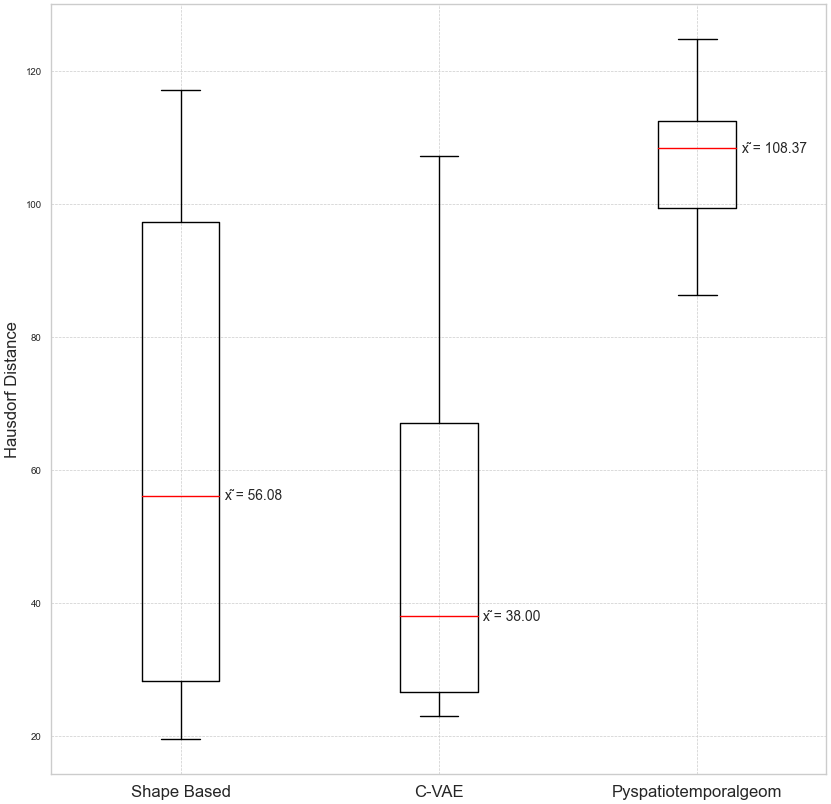

In [250]:
# Combine the data into a list
data = [hd_list_shp_ts, hd_list_cvae_ts, hd_list_pstg_ts]

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 10))

# Create the boxplot with median annotation
boxplot = ax.boxplot(data, labels=['Shape Based', 'C-VAE', 'Pyspatiotemporalgeom'],
                        medianprops={'linewidth': 1, 'color': 'red'},
                        flierprops=dict(markerfacecolor='r', markersize=2),
                        showfliers=False,
                        patch_artist=False)

# Add dashed gridlines
ax.grid(linestyle='--', linewidth=0.5)
    
# # Add annotation for median values
for i, box in enumerate(boxplot['medians']):
    ax.annotate(f" x͂ = {box.get_ydata()[0]:.2f}", 
                xy=(i+1, box.get_ydata()[0]), 
                xytext=(29, 0),
                textcoords='offset points',
                va='center')
ax.set_ylabel('Hausdorf Distance')
# set title
# ax.set_title(title)
# x label size
ax.tick_params(axis='x', labelsize=12)

# Show the plot
plt.show()

Text(0, 0.5, 'Haussdorf Distance')

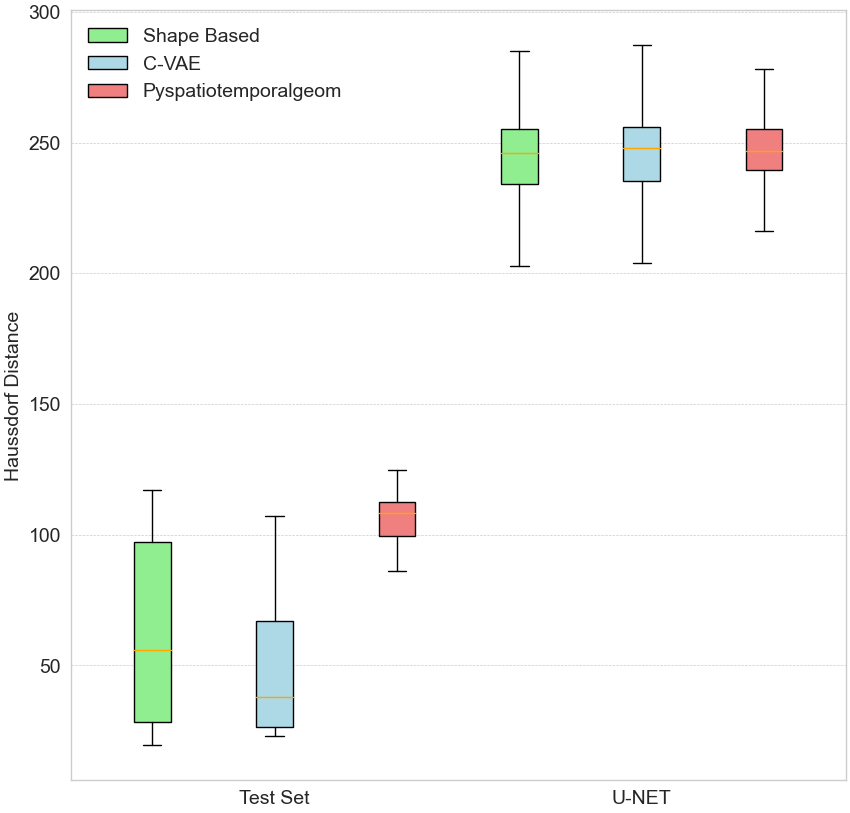

In [265]:
data_ts = [hd_list_shp_ts, hd_list_cvae_ts, hd_list_pstg_ts]
data_pr = [hd_list_shp_pr, hd_list_cvae_pr, hd_list_pstg_pr]

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 10))

# left position of bars on x-axis
left = [0.75, 1.5, 2.25]
# right position of bars on x-axis
right = [3, 3.75, 4.5]

# labels for bars
tick_label = ['Shape Based', 'C-VAE', 'Pyspatiotemporalgeom']

# Create the boxplot with median annotation, showfliers=False, shape based green, cvae blue, pstg red
boxplot_ts = ax.boxplot(data_ts,
                        positions=left,
                        medianprops={'linewidth': 1, 'color': 'orange'},
                        showfliers=False,
                        flierprops=dict(markerfacecolor='r', markersize=2),
                        patch_artist=True)

# Create the boxplot with median annotation, showfliers=False, shape based green, cvae blue, pstg red
boxplot_unet = ax.boxplot(data_pr,
                        positions=right,
                        medianprops={'linewidth': 1, 'color': 'orange'},
                        showfliers=False,
                        flierprops=dict(markerfacecolor='r', markersize=2),
                        patch_artist=True)

colors = ['lightgreen', 'lightblue', 'lightcoral', 'lightgreen', 'lightblue', 'lightcoral']
for patch, color in zip(boxplot_ts['boxes'], colors):
    patch.set_facecolor(color)

for patch, color in zip(boxplot_unet['boxes'], colors):
    patch.set_facecolor(color)

# Add dashed gridlines for y axis ONLY
ax.grid(linestyle='--', linewidth=0.5, axis='y')
# no x gridlines
ax.grid(False, axis='x')

# x labels
ax.set_xticks([1.5, 3.75])
ax.set_xticklabels(['Test Set', 'U-NET'])
# increase4 font size
ax.tick_params(axis='both', which='major', labelsize=14)

# add legend for each model, font size 14
ax.legend([boxplot_ts["boxes"][0], boxplot_ts["boxes"][1], boxplot_ts["boxes"][2]],
            ['Shape Based', 'C-VAE', 'Pyspatiotemporalgeom'], fontsize=14)  
# add y label
ax.set_ylabel('Haussdorf Distance', fontsize=14)

### IoU - Test Set

In [37]:
# CVAE
model_polys = [loads(wkt) for wkt in cvae_wkt]
iou_list_cvae_pr_ts  = list()
print("Calculating IoU...")
for i in range(len(g_t_polys)):
    iou = g_t_polys[i].intersection(model_polys[i]).area / g_t_polys[i].union(model_polys[i]).area
    iou_list_cvae_pr_ts .append(iou)
    
iou_mean_cvae_pr_ts = sum(iou_list_cvae) / len(iou_list_cvae)

Calculating IoU...


In [38]:
# Shape based
model_polys = [loads(wkt) for wkt in shp_wkt]
iou_list_shp_pr_ts  = list()
print("Calculating IoU...")
for i in range(len(g_t_polys)):
    iou = g_t_polys[i].intersection(model_polys[i]).area / g_t_polys[i].union(model_polys[i]).area
    iou_list_shp_pr_ts .append(iou)

iou_mean_shp_pr_ts = sum(iou_list_shp) / len(iou_list_shp)

Calculating IoU...


In [39]:
# Pyspatiotemporalgeom
model_polys = [loads(wkt) for wkt in pstg_wkt]
iou_list_pstg_pr_ts  = list()
print("Calculating IoU...")
for i in range(len(g_t_polys)):
    iou = g_t_polys[i].intersection(model_polys[i]).area / g_t_polys[i].union(model_polys[i]).area
    iou_list_pstg_pr_ts .append(iou)

iou_mean_pstg_pr_ts = sum(iou_list_pstg) / len(iou_list_pstg)

Calculating IoU...


In [40]:
print(f"Conditional VAE interpolation: mean IoU {iou_mean_cvae_pr_ts:.3f} \n")
print(f"Shape based interpolation: mean IoU {iou_mean_shp_pr_ts:.3f} \n")
print(f"Pyspatiotemporalgeom interpolation: mean IoU {iou_mean_pstg_pr_ts:.3f} \n")

Conditional VAE interpolation: mean IoU 0.949 

Shape based interpolation: mean IoU 0.959 

Pyspatiotemporalgeom interpolation: mean IoU 0.822 



In [197]:
3.75 + 0.75

4.5

### Boxplots: IoU Test Set

Text(0, 0.5, 'Jaccard Index')

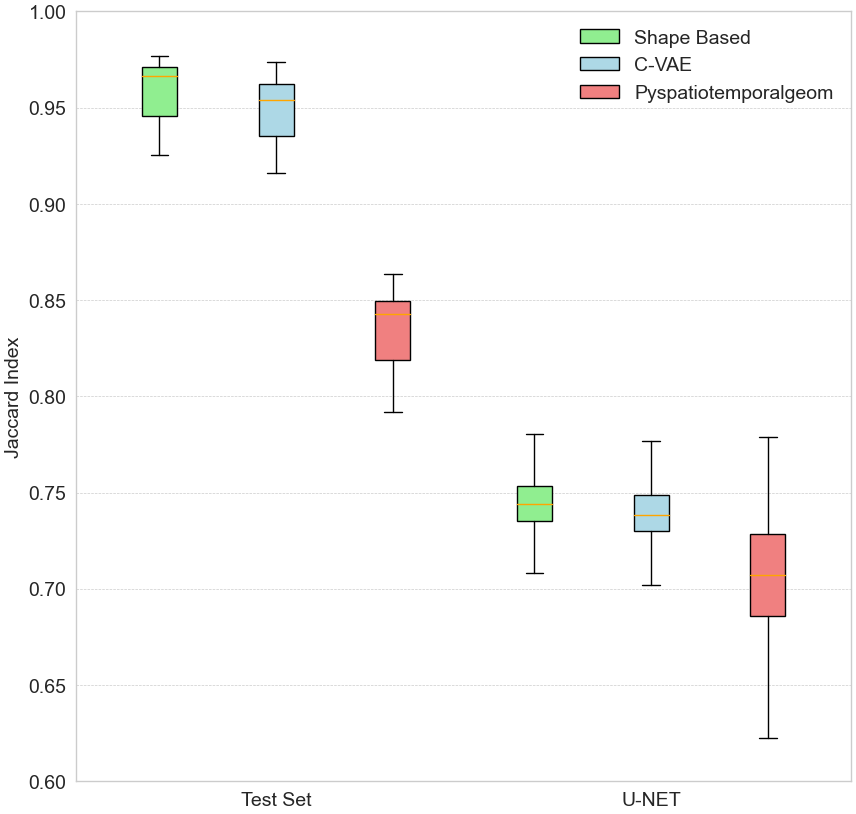

In [263]:
# plot IoU for UNET and test set comparison
# Combine the data into a list
data_ts = [iou_list_shp_pr_ts, iou_list_cvae_pr_ts, iou_list_pstg_pr_ts]
data_unet = [iou_list_shp_pr, iou_list_cvae_pr, iou_list_pstg_pr]

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 10))

# y-axis from 0 to 1
ax.set_ylim(0.6, 1)

# left position of bars on x-axis
left = [0.8, 1.5, 2.2]
# right position of bars on x-axis
right = [3.05, 3.75, 4.45]
 
# labels for bars
tick_label = ['Shape Based', 'C-VAE', 'Pyspatiotemporalgeom']

# Create the boxplot with median annotation, showfliers=False, shape based green, cvae blue, pstg red
boxplot_ts = ax.boxplot(data_ts,
                        positions=left,
                        medianprops={'linewidth': 1, 'color': 'orange'},
                        showfliers=False,
                        flierprops=dict(markerfacecolor='r', markersize=2),
                        patch_artist=True)

# Create the boxplot with median annotation, showfliers=False, shape based green, cvae blue, pstg red
boxplot_unet = ax.boxplot(data_unet,
                        positions=right,
                        medianprops={'linewidth': 1, 'color': 'orange'},
                        showfliers=False,
                        flierprops=dict(markerfacecolor='r', markersize=2),
                        patch_artist=True)
                    

colors = ['lightgreen', 'lightblue', 'lightcoral', 'lightgreen', 'lightblue', 'lightcoral']
for patch, color in zip(boxplot_ts['boxes'], colors):
    patch.set_facecolor(color)

for patch, color in zip(boxplot_unet['boxes'], colors):
    patch.set_facecolor(color)

# Add dashed gridlines for y axis ONLY
ax.grid(linestyle='--', linewidth=0.5, axis='y')
# no x gridlines
ax.grid(False, axis='x')

# x labels
ax.set_xticks([1.5, 3.75])
ax.set_xticklabels(['Test Set', 'U-NET'])
# increase4 font size
ax.tick_params(axis='both', which='major', labelsize=14)

# add legend for each model, font size 14
ax.legend([boxplot_ts["boxes"][0], boxplot_ts["boxes"][1], boxplot_ts["boxes"][2]],
            ['Shape Based', 'C-VAE', 'Pyspatiotemporalgeom'], fontsize=14)  
# add y label
ax.set_ylabel('Jaccard Index', fontsize=14)

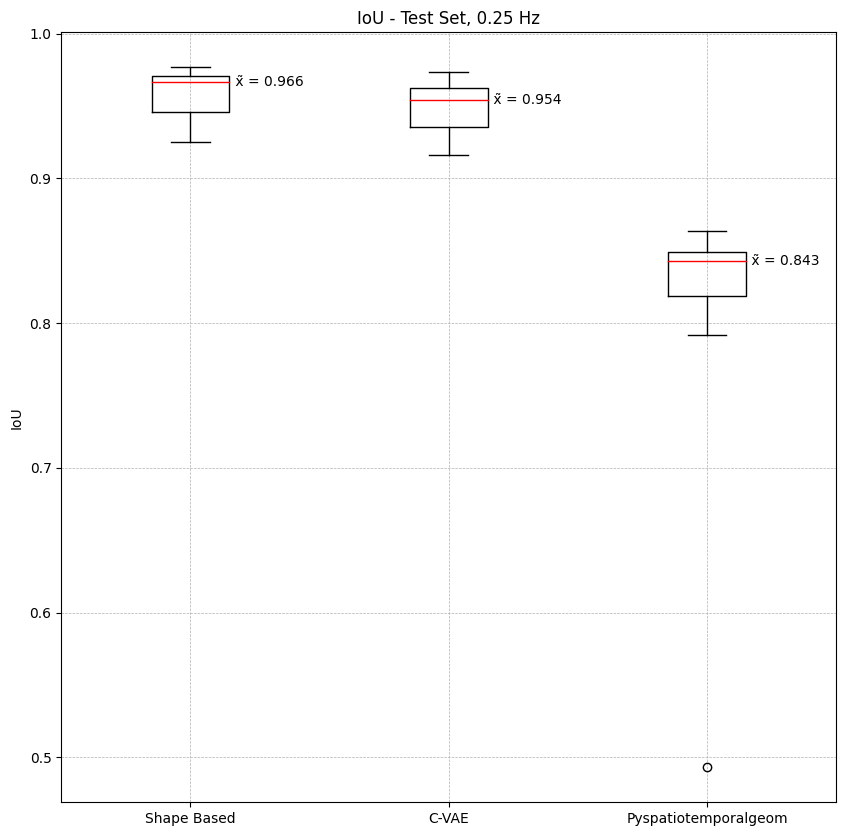

In [80]:
# IoU boxplots in one figure
# Combine the data into a list
data = [iou_list_shp_pr_ts, iou_list_cvae_pr_ts, iou_list_pstg_pr_ts]

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 10))

# Create the boxplot with median annotation
boxplot = ax.boxplot(data, labels=['Shape Based', 'C-VAE', 'Pyspatiotemporalgeom'],
                        medianprops={'linewidth': 1, 'color': 'red'},
                        flierprops=dict(markerfacecolor='r', markersize=2),   
                        patch_artist=False)

# Add dashed gridlines
ax.grid(linestyle='--', linewidth=0.5)

# # Add annotation for median values
for i, box in enumerate(boxplot['medians']):
    ax.annotate(f" x͂ = {box.get_ydata()[0]:.3f}", 
                xy=(i+1, box.get_ydata()[0]), 
                xytext=(29, 0),
                textcoords='offset points',
                va='center')
ax.set_ylabel('IoU')
title = "IoU - Test Set, 0.25 Hz"
ax.set_title(title)
plt.show()

## Temporal Consistency (0,25 Hz Interpolations)

### Exponetial Strided TC

In [162]:
# Let a_n be some geometric progression a_n = a_1*r^(n−1)
n = np.arange(1,6)
a_1 = 1
r = 10
# calculate the geometric progression
a_n = a_1*r**(n-1)
strides = a_n
print(f"strides: {strides}")

strides: [    1    10   100  1000 10000]


In [167]:
# CVAE
print("Reading WKTs file...")
with open(CVAE_WKT_FILE, "r") as f:
    model_wkt = f.read().splitlines()

# delete samples
del model_wkt[::100]
num_polygons = len(model_wkt)

# read WKTS file lines and convert to list of shapely polygons
polygons = [loads(wkt) for wkt in model_wkt]
polygons = polygons[:num_polygons]
tc_list = list()

for str in strides:
    t_c = strided_temporal_consistency(polygons, num_polygons, str)
    print(f"Conditional VAE interpolation: mean TC {t_c['tc_mean']:.4e} with stride {t_c['strd']} \n")
    tc_list.append(t_c)

Reading WKTs file...
Calculating the temporal consistency with stride 1...
Conditional VAE interpolation: mean TC 9.7589e-01 with stride 1 

Calculating the temporal consistency with stride 10...
Conditional VAE interpolation: mean TC 9.7769e-01 with stride 10 

Calculating the temporal consistency with stride 100...
Conditional VAE interpolation: mean TC 9.7935e-01 with stride 100 

Calculating the temporal consistency with stride 1000...
Conditional VAE interpolation: mean TC 8.8469e-01 with stride 1000 

Calculating the temporal consistency with stride 10000...
Conditional VAE interpolation: mean TC 8.1879e-01 with stride 10000 



In [168]:
# Shape based
print("Reading WKTs file...")
with open(SHP_WKT_FILE, "r") as f:
    model_wkt = f.read().splitlines()

# delete samples
del model_wkt[::100]
num_polygons = len(model_wkt)

# read WKTS file lines and convert to list of shapely polygons
polygons = [loads(wkt) for wkt in model_wkt]
polygons = polygons[:num_polygons]

tc_shp_list = list()
for str in strides:
    t_c = strided_temporal_consistency(polygons, num_polygons, str)
    print(f"Shape based interpolation: mean TC {t_c['tc_mean']:.4e} with stride {t_c['strd']} \n")
    tc_shp_list.append(t_c)

Reading WKTs file...
Calculating the temporal consistency with stride 1...
Shape based interpolation: mean TC 9.9743e-01 with stride 1 

Calculating the temporal consistency with stride 10...
Shape based interpolation: mean TC 9.7477e-01 with stride 10 

Calculating the temporal consistency with stride 100...
Shape based interpolation: mean TC 8.2133e-01 with stride 100 

Calculating the temporal consistency with stride 1000...
Shape based interpolation: mean TC 7.4793e-01 with stride 1000 

Calculating the temporal consistency with stride 10000...
Shape based interpolation: mean TC 7.5838e-01 with stride 10000 



In [169]:
# Pyspatiotemporalgeom
print("Reading WKTs file...")
with open( PSTG_WKT_FILE, "r") as f:
    model_wkt = f.read().splitlines()

# delete samples
del model_wkt[::100]
num_polygons = len(model_wkt)

# read WKTS file lines and convert to list of shapely polygons
polygons = [loads(wkt) for wkt in model_wkt]
polygons = polygons[:num_polygons]

tc_pstg_list = list()

for str in strides:
    t_c = strided_temporal_consistency(polygons, num_polygons, str)
    print(f"Pyspatiotemporalgeom interpolation: mean TC {t_c['tc_mean']:.4e} with stride {t_c['strd']} \n")
    tc_pstg_list.append(t_c)

Reading WKTs file...
Calculating the temporal consistency with stride 1...


c:\Users\tiago\miniconda3\envs\interpol\lib\site-packages\shapely\set_operations.py:77: RuntimeWarning: invalid value encountered in difference
  return lib.difference(a, b, **kwargs)


Pyspatiotemporalgeom interpolation: mean TC 9.5364e-01 with stride 1 

Calculating the temporal consistency with stride 10...
Pyspatiotemporalgeom interpolation: mean TC 7.3085e-01 with stride 10 

Calculating the temporal consistency with stride 100...
Pyspatiotemporalgeom interpolation: mean TC 6.4983e-01 with stride 100 

Calculating the temporal consistency with stride 1000...
Pyspatiotemporalgeom interpolation: mean TC 6.3958e-01 with stride 1000 

Calculating the temporal consistency with stride 10000...
Pyspatiotemporalgeom interpolation: mean TC 8.8656e-01 with stride 10000 



In [170]:
print(f"Conditional VAE interpolation: mean TC {sum([tc['tc_mean'] for tc in tc_list])/len(tc_list):.4e} \n")
print(f"Shape based interpolation: mean TC {sum([tc['tc_mean'] for tc in tc_shp_list])/len(tc_shp_list):.4e} \n")   
print(f"Pyspatiotemporalgeom interpolation: mean TC {sum([tc['tc_mean'] for tc in tc_pstg_list])/len(tc_pstg_list):.4e} \n")

Conditional VAE interpolation: mean TC 9.2728e-01 

Shape based interpolation: mean TC 8.5997e-01 

Pyspatiotemporalgeom interpolation: mean TC 7.7209e-01 



### Boxplots and tables: Exp. Strided TC

Text(0.5, 0, 'Stride')

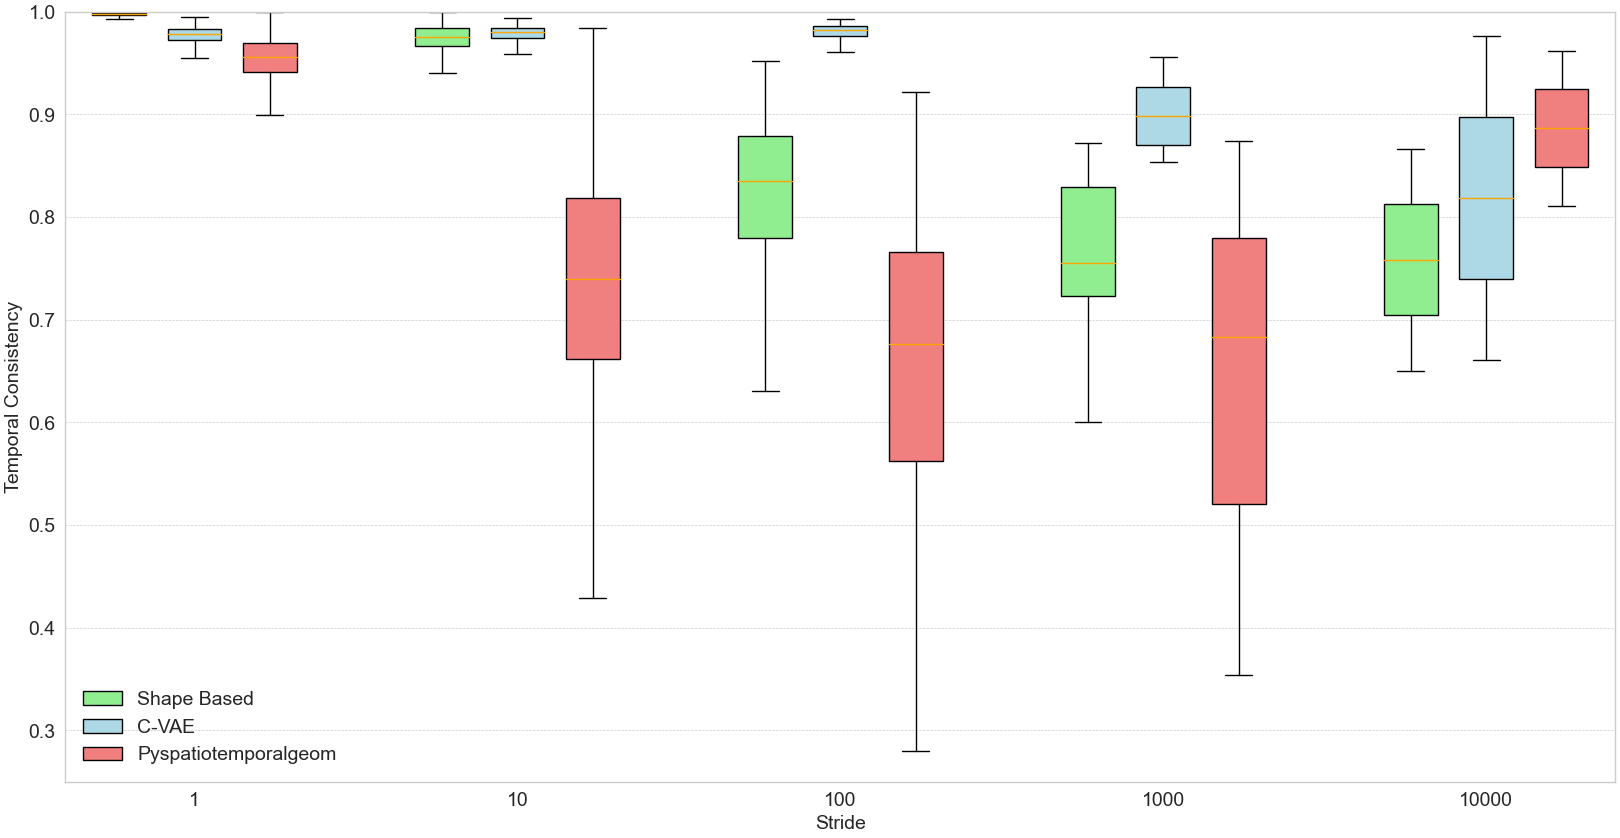

In [235]:

# combine the data into a list and orders it according to the stide values
data = [tc_shp_list[0]['tc'], tc_list[0]['tc'], tc_pstg_list[0]['tc'],
        tc_shp_list[1]['tc'], tc_list[1]['tc'], tc_pstg_list[1]['tc'],
        tc_shp_list[2]['tc'], tc_list[2]['tc'], tc_pstg_list[2]['tc'],
        tc_shp_list[3]['tc'], tc_list[3]['tc'], tc_pstg_list[3]['tc'],
        tc_shp_list[4]['tc'], tc_list[4]['tc'], tc_pstg_list[4]['tc']]


        
# Set up the figure and axes
fig, ax = plt.subplots(figsize=(20, 10))

# y-axis from 0 to 1
ax.set_ylim(0.25, 1)

# positions of the boxplots
pos = [1.3, 2, 2.7, 4.3, 5, 5.7, 7.3, 8, 8.7, 10.3, 11, 11.7, 13.3, 14, 14.7]

# Create the boxplot with median annotation, showfliers=False, shape based green, cvae blue, pstg red
boxplot = ax.boxplot(data,
                        positions=pos,
                        medianprops={'linewidth': 1, 'color': 'orange'},
                        showfliers=False,
                        flierprops=dict(markerfacecolor='r', markersize=2),
                        patch_artist=True)

colors = ['lightgreen', 'lightblue', 'lightcoral'] *5

for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)

ax.set_xticks([2, 5, 8, 11, 14]);
ax.set_xticklabels(['1', '10', '100', '1000', '10000']);

# Add dashed gridlines for y axis ONLY
ax.grid(linestyle='--', linewidth=0.5, axis='y')
ax.grid(False, axis='x')

# increase4 font size
ax.tick_params(axis='both', which='major', labelsize=14)

# add legend for each model, font size 14
ax.legend([boxplot["boxes"][0], boxplot["boxes"][1], boxplot["boxes"][2]],
            ['Shape Based', 'C-VAE', 'Pyspatiotemporalgeom'], fontsize=14)  
# add y label
ax.set_ylabel('Temporal Consistency', fontsize=14)

# add x label
ax.set_xlabel('Stride', fontsize=14)

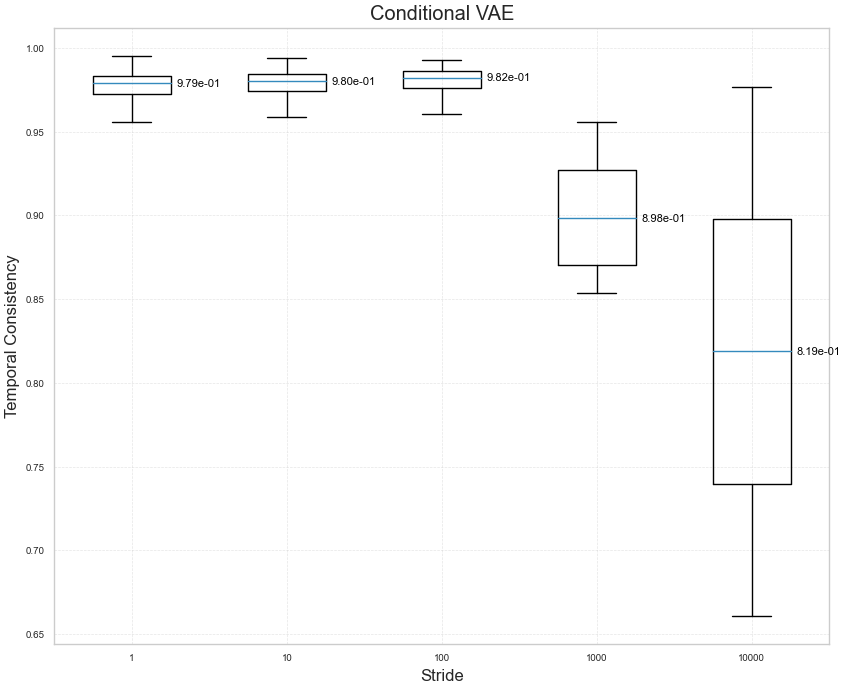

In [193]:
# CVAE boxplots in a single figure
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title('Conditional VAE')
# boxplot with all the values
# ax.boxplot([tc_list[i]["tc"] for i in range(0, stride_rng)])
# smaller outliers

ax.boxplot([tc_list[i]["tc"] for i in range(0, len(strides))], 
           flierprops=dict(markerfacecolor='r', markersize=1),
           showfliers=False)  

ax.set_xlabel("Stride")
ax.set_ylabel("Temporal Consistency")

# # add annotations with the median value
for i in range(0,  len(strides)):
    ax.annotate(f"{np.median(tc_list[i]['tc']):.2e}", (i+1, 
                np.median(tc_list[i]['tc'])), ha='left', va='center', 
                size=8, color='black', xytext=(32, 0), 
                textcoords='offset points')
    
ax.set_xticklabels(strides)

ax.grid( linestyle="--", alpha=0.5)
plt.show()

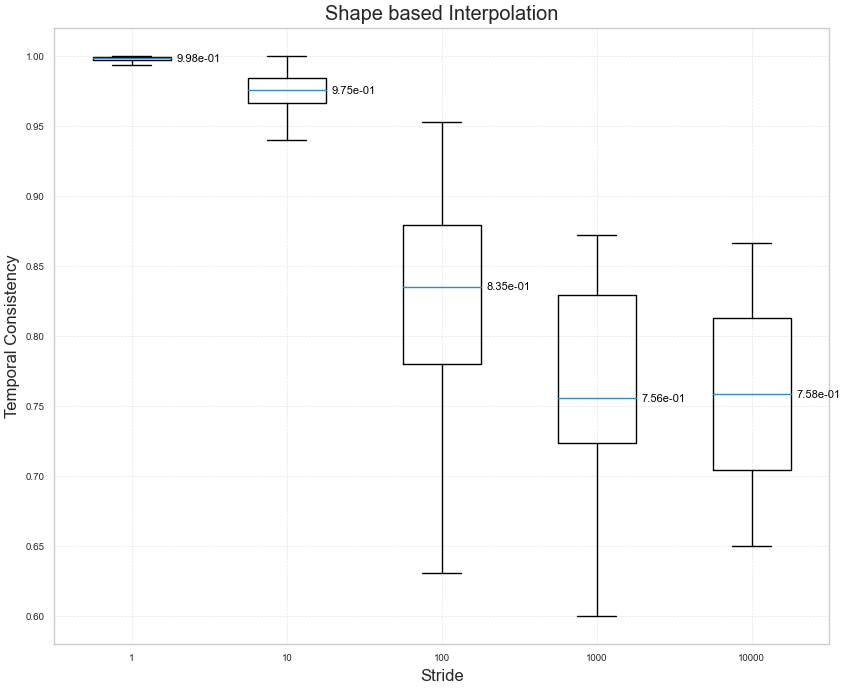

In [191]:
# Shape based boxplots in a single figure
fig, ax = plt.subplots(figsize=(10, 8))
# plots style
ax.set_title('Shape based Interpolation')
# boxplot with all the values
# ax.boxplot([tc_list[i]["tc"] for i in range(0, stride_rng)])
# smaller outliers
ax.boxplot([tc_shp_list[i]["tc"] for i in range(0, len(strides))] ,
              flierprops=dict(markerfacecolor='r', markersize=1),
              showfliers=False)       

ax.set_xlabel("Stride")
ax.set_ylabel("Temporal Consistency")

# # add annotations with the median value
for i in range(0,  len(strides)):
    ax.annotate(f"{np.median(tc_shp_list[i]['tc']):.2e}", (i+1, 
                np.median(tc_shp_list[i]['tc'])), ha='left', va='center', 
                size=8, color='black', xytext=(32, 0), 
                textcoords='offset points')
    
ax.set_xticklabels(strides)

ax.grid( linestyle="--", alpha=0.5)
plt.show()

C:\Users\tiago\AppData\Local\Temp\ipykernel_28620\4077152872.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


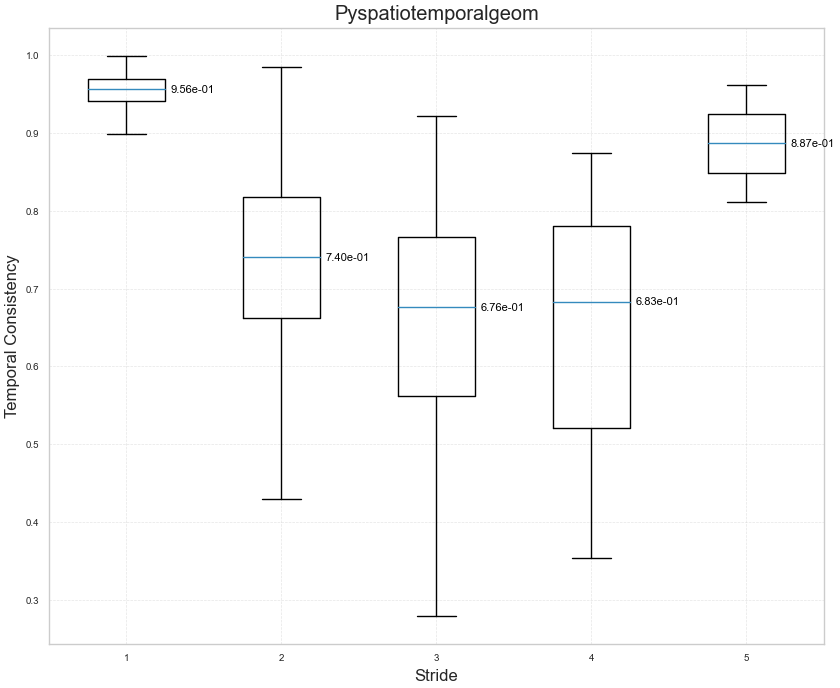

In [190]:
# Pyspatiotemporalgeom boxplots in a single figure
fig, ax = plt.subplots(figsize=(10, 8))
# plots style
plt.style.use('seaborn-whitegrid')
ax.set_title('Pyspatiotemporalgeom')
# boxplot with all the values
# ax.boxplot([tc_list[i]["tc"] for i in range(0, stride_rng)])
# smaller outliers
ax.boxplot([tc_pstg_list[i]["tc"] for i in range(0, len(strides))],
                flierprops=dict(markerfacecolor='r', markersize=1),
                showfliers=False)

ax.set_xlabel("Stride")
ax.set_ylabel("Temporal Consistency")

# add annotations with the median value
for i in range(0, len(strides)):
    ax.annotate(f"{np.median(tc_pstg_list[i]['tc']):.2e}", (i+1, 
                np.median(tc_pstg_list[i]['tc'])), ha='left', va='center', 
                size=8, color='black', xytext=(32, 0), 
                textcoords='offset points')
                
ax.grid( linestyle="--", alpha=0.5)
plt.show()


# Distance Sampled Interpolations

## Comparison with **UNET** generated segmentations

### IoU

In [105]:
iou_shp_mean_dst, iou_list_shp_dst = iou_wkt(UNET_WKT_FILE, SHP_WKT_FILE_SAMPLED, num_polygons=NUM_POLYGONS)
iou_cvae_mean_dst, iou_list_cvae_dst = iou_wkt(UNET_WKT_FILE, CVAE_WKT_FILE_SAMPLED, num_polygons=NUM_POLYGONS)
iou_pstg_mean_dst, iou_list_pstg_dst = iou_wkt(UNET_WKT_FILE, PSTG_WKT_FILE_SAMPLED, num_polygons=NUM_POLYGONS)

Reading WKTs files...
Calculating IoU...
Reading WKTs files...
Calculating IoU...
Reading WKTs files...
Calculating IoU...


In [106]:
print(f"Shape based interpolation: meanIou {iou_shp_mean_dst:.3f} \n")
print(f"Conditional VAE interpolation: meanIoU {iou_cvae_mean_dst:.3f} \n")
print(f"Pyspatiotemporalgeom interpolation: meanIoU {iou_pstg_mean_dst:.3f} \n")

Shape based interpolation: meanIou 0.738 

Conditional VAE interpolation: meanIoU 0.723 

Pyspatiotemporalgeom interpolation: meanIoU 0.697 



### Boxplots for the IoU 

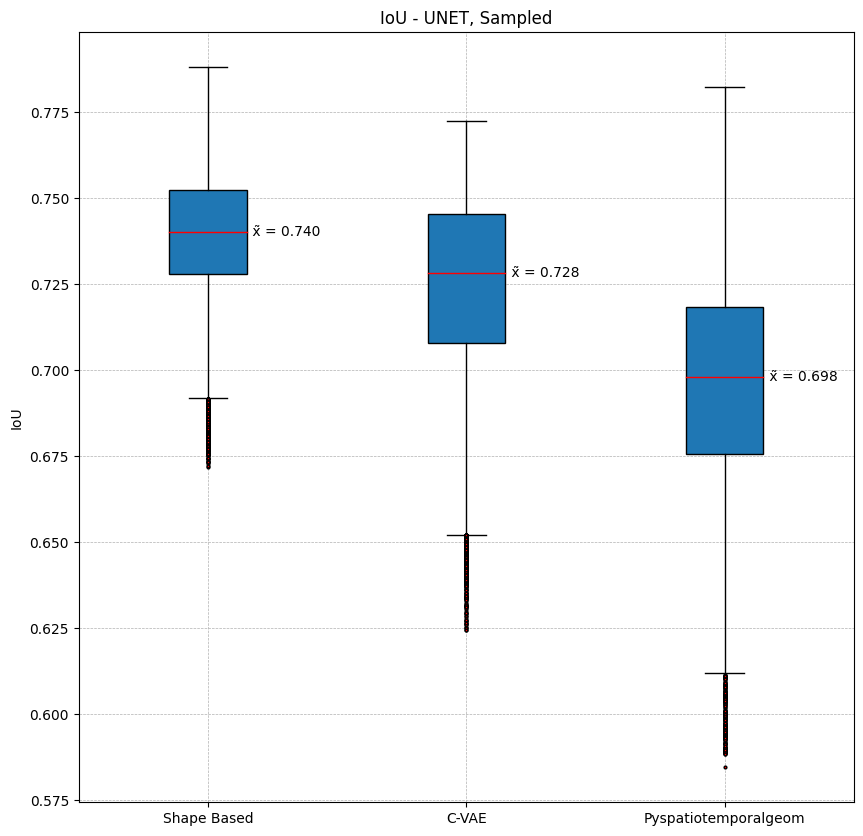

In [148]:
# Combine the data into a list
data = [iou_list_shp, iou_list_cvae, iou_list_pstg]

fig, ax = plt.subplots(figsize=(10, 10))

boxplot = ax.boxplot(data, labels=['Shape Based', 'C-VAE', 'Pyspatiotemporalgeom'], 
                     medianprops={'linewidth': 1, 'color': 'red'},
                     flierprops=dict(markerfacecolor='r', markersize=2),
                     patch_artist=True)

# Add dashed gridlines
ax.grid(linestyle='--', linewidth=0.5)

# Add annotation for median values
for i, box in enumerate(boxplot['medians']):
    ax.annotate(f" x͂ = {box.get_ydata()[0]:.3f}", 
                xy=(i+1, box.get_ydata()[0]), 
                xytext=(29, 0),
                textcoords='offset points',
                va='center')
ax.set_ylabel('IoU')
ax.set_title('IoU - UNET, Sampled')

# Show the plot
plt.show();

### Hausdorf Distance

In [260]:
hd_shp_mean_pr_sp, hd_list_shp_pr_sp = hausdorff_dist_wkt(UNET_WKT_FILE, SHP_WKT_FILE_SAMPLED, last_frame=NUM_POLYGONS, discard_100=True)
hd_cvae_mean_pr_sp, hd_list_cvae_pr_sp = hausdorff_dist_wkt(UNET_WKT_FILE, CVAE_WKT_FILE_SAMPLED, last_frame=NUM_POLYGONS, discard_100=True)
hd_pstg_mean_pr_sp, hd_list_pstg_pr_sp = hausdorff_dist_wkt(UNET_WKT_FILE, PSTG_WKT_FILE_SAMPLED, last_frame=NUM_POLYGONS, discard_100=True)

Reading WKTs files...
Calculating Hausdorf Distance...
Reading WKTs files...
Calculating Hausdorf Distance...
Reading WKTs files...
Calculating Hausdorf Distance...


In [261]:
print(f"Shape based interpolation: mean Hausdorf Dist. {hd_shp_mean_pr_sp:.3f} \n")
print(f"Conditional VAE interpolation: mean Hausdorf Dist. {hd_cvae_mean_pr_sp:.3f} \n")
print(f"Pyspatiotemporalgeom interpolation: mean Hausdorf Dist. {hd_pstg_mean_pr_sp:.3f} \n")

Shape based interpolation: mean Hausdorf Dist. 221.245 

Conditional VAE interpolation: mean Hausdorf Dist. 245.071 

Pyspatiotemporalgeom interpolation: mean Hausdorf Dist. 241.100 



### Boxplots for Hausdord Distance

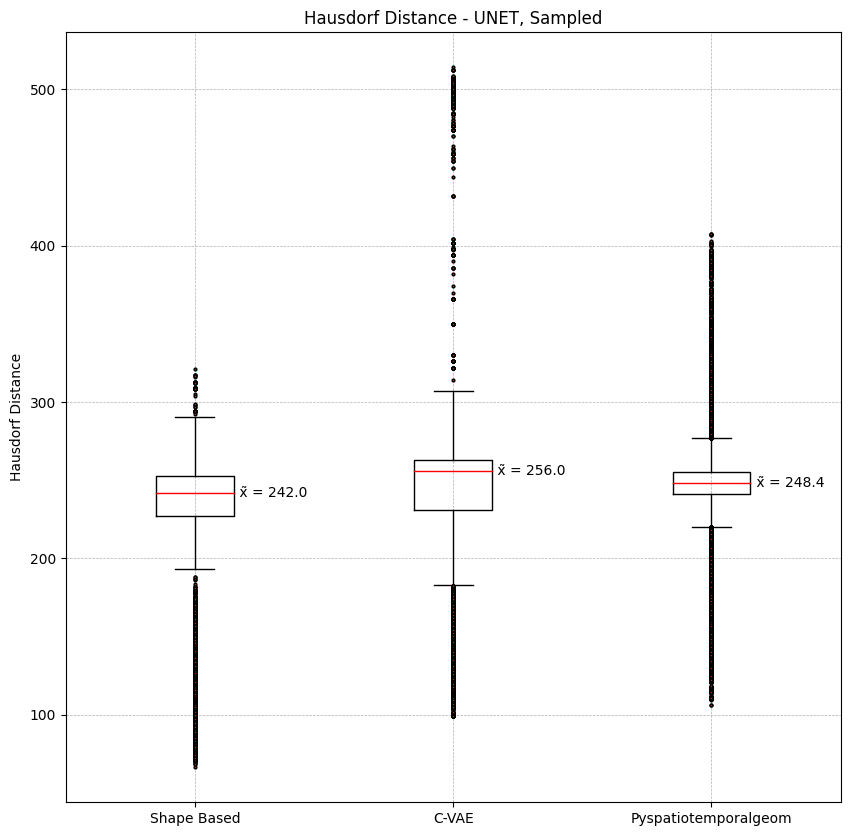

In [150]:
# Combine the data into a list
data = [hd_list_shp, hd_list_cvae, hd_list_pstg]

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 10))

# Create the boxplot with median annotation
boxplot = ax.boxplot(data, labels=['Shape Based', 'C-VAE', 'Pyspatiotemporalgeom'], 
                     medianprops={'linewidth': 1, 'color': 'red'},
                     flierprops=dict(markerfacecolor='r', markersize=2), 
                     patch_artist=False)

# Add dashed gridlines
ax.grid(linestyle='--', linewidth=0.5)

# # Add annotation for median values
for i, box in enumerate(boxplot['medians']):
    ax.annotate(f" x͂ = {box.get_ydata()[0]:.1f}", 
                xy=(i+1, box.get_ydata()[0]), 
                xytext=(29, 0),
                textcoords='offset points',
                va='center')
ax.set_ylabel('Hausdorf Distance')

ax.set_title('Hausdorf Distance - UNET, Sampled')

# Show the plot
plt.show()

## Comparison with the BurnedAreaUAV **Test set**

### Data preparation

In [255]:
# test set frame indexes 
idx = np.linspace(20250, 22450, 23).astype(int)  

# Read WKTS files
print("Reading WKTs files...")
with open(BA_UAV_WKT, "r") as f:
    test_wkt = f.read().splitlines()

with open(SHP_WKT_FILE_SAMPLED, "r") as f:
    shp_wkt = f.read().splitlines()

with open(CVAE_WKT_FILE_SAMPLED, "r") as f:
    cvae_wkt = f.read().splitlines()

with open(PSTG_WKT_FILE_SAMPLED, "r") as f:
    pstg_wkt = f.read().splitlines()

print("Filtering WKTs files...")
shp_wkt = [shp_wkt[i] for i in idx]
cvae_wkt = [cvae_wkt[i] for i in idx]
pstg_wkt = [pstg_wkt[i] for i in idx]
# print the length of all wkt files
print(f"Shape based interpolation: {len(shp_wkt)} frames")
print(f"Conditional VAE interpolation: {len(cvae_wkt)} frames")
print(f"Pyspatiotemporalgeom interpolation: {len(pstg_wkt)} frames ")
print(f"Test set: {len(test_wkt)} frames")

Reading WKTs files...
Filtering WKTs files...
Shape based interpolation: 23 frames
Conditional VAE interpolation: 23 frames
Pyspatiotemporalgeom interpolation: 23 frames 
Test set: 23 frames


### Hausdorf Distance 

In [254]:
# converts Test set ground truth polygon to shapely format
g_t_polys = [loads(wkt) for wkt in test_wkt]

# Shape based interpolation
model_polys = [loads(wkt) for wkt in shp_wkt]
hd_list_shp_ts_sp  = list()
print("Calculating Hausdorf Distance...")
for i in range(len(g_t_polys)):
    g_t_polys[i] =  make_valid(g_t_polys[i])
    model_polys[i] = make_valid(model_polys[i])
    hausdorff_dist = g_t_polys[i].hausdorff_distance(model_polys[i])
    hd_list_shp_ts_sp.append(hausdorff_dist)    

hd_mean_shp_ts_sp = np.mean(hd_list_shp_ts_sp)

Calculating Hausdorf Distance...


c:\Users\tiago\miniconda3\envs\interpol\lib\site-packages\shapely\measurement.py:224: RuntimeWarning: invalid value encountered in hausdorff_distance
  return lib.hausdorff_distance(a, b, **kwargs)
c:\Users\tiago\miniconda3\envs\interpol\lib\site-packages\shapely\measurement.py:224: RuntimeWarning: invalid value encountered in hausdorff_distance
  return lib.hausdorff_distance(a, b, **kwargs)
c:\Users\tiago\miniconda3\envs\interpol\lib\site-packages\shapely\measurement.py:224: RuntimeWarning: invalid value encountered in hausdorff_distance
  return lib.hausdorff_distance(a, b, **kwargs)
c:\Users\tiago\miniconda3\envs\interpol\lib\site-packages\shapely\measurement.py:224: RuntimeWarning: invalid value encountered in hausdorff_distance
  return lib.hausdorff_distance(a, b, **kwargs)


In [256]:
# CVAE
model_polys = [loads(wkt) for wkt in cvae_wkt]
hd_list_cvae_ts_sp = list()
print("Calculating Hausdorf Distance...")
for i in range(len(g_t_polys)):
    g_t_polys[i]=  make_valid(g_t_polys[i])
    model_polys[i] = make_valid(model_polys[i])
    hausdorff_dist = g_t_polys[i].hausdorff_distance(model_polys[i])
    hd_list_cvae_ts_sp.append(hausdorff_dist)    

hd_mean_cvae_ts_sp = np.mean(hd_list_cvae_ts_sp)

Calculating Hausdorf Distance...


c:\Users\tiago\miniconda3\envs\interpol\lib\site-packages\shapely\measurement.py:224: RuntimeWarning: invalid value encountered in hausdorff_distance
  return lib.hausdorff_distance(a, b, **kwargs)
c:\Users\tiago\miniconda3\envs\interpol\lib\site-packages\shapely\measurement.py:224: RuntimeWarning: invalid value encountered in hausdorff_distance
  return lib.hausdorff_distance(a, b, **kwargs)
c:\Users\tiago\miniconda3\envs\interpol\lib\site-packages\shapely\measurement.py:224: RuntimeWarning: invalid value encountered in hausdorff_distance
  return lib.hausdorff_distance(a, b, **kwargs)
c:\Users\tiago\miniconda3\envs\interpol\lib\site-packages\shapely\measurement.py:224: RuntimeWarning: invalid value encountered in hausdorff_distance
  return lib.hausdorff_distance(a, b, **kwargs)


In [257]:
# PSTG
model_polys = [loads(wkt) for wkt in pstg_wkt]
hd_list_pstg_ts_sp = list()
print("Calculating Hausdorf Distance...")
for i in range(len(g_t_polys)):
    g_t_polys[i]=  make_valid(g_t_polys[i])
    model_polys[i] = make_valid(model_polys[i])
    hausdorff_dist = g_t_polys[i].hausdorff_distance(model_polys[i])
    hd_list_pstg_ts_sp.append(hausdorff_dist)    

hd_mean_pstg_ts_sp = np.mean(hd_list_pstg_ts_sp)

Calculating Hausdorf Distance...


c:\Users\tiago\miniconda3\envs\interpol\lib\site-packages\shapely\measurement.py:224: RuntimeWarning: invalid value encountered in hausdorff_distance
  return lib.hausdorff_distance(a, b, **kwargs)
c:\Users\tiago\miniconda3\envs\interpol\lib\site-packages\shapely\measurement.py:224: RuntimeWarning: invalid value encountered in hausdorff_distance
  return lib.hausdorff_distance(a, b, **kwargs)
c:\Users\tiago\miniconda3\envs\interpol\lib\site-packages\shapely\measurement.py:224: RuntimeWarning: invalid value encountered in hausdorff_distance
  return lib.hausdorff_distance(a, b, **kwargs)
c:\Users\tiago\miniconda3\envs\interpol\lib\site-packages\shapely\measurement.py:224: RuntimeWarning: invalid value encountered in hausdorff_distance
  return lib.hausdorff_distance(a, b, **kwargs)


In [258]:
print("Distance Sampled Interpolation")
print(f"Conditional VAE interpolation: mean Hausdorf Dist. {hd_mean_cvae_ts_sp:.3f} \n")
print(f"Shape based interpolation: mean Hausdorf Dist. {hd_mean_shp_ts_sp:.3f} \n")
print(f"Pyspatiotemporalgeom interpolation: mean Hausdorf Dist. {hd_mean_pstg_ts_sp:.3f} \n")

Distance Sampled Interpolation
Conditional VAE interpolation: mean Hausdorf Dist. 85.220 

Shape based interpolation: mean Hausdorf Dist. 60.815 

Pyspatiotemporalgeom interpolation: mean Hausdorf Dist. 103.068 



### Boxplots: Hausdorf Distance Test

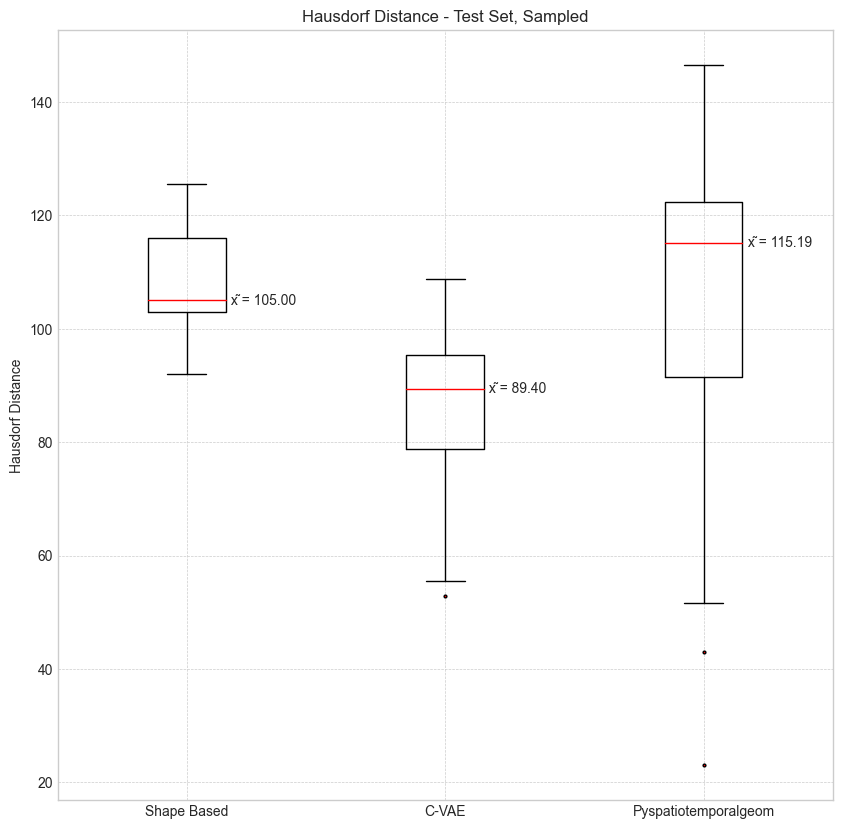

In [207]:
# Combine the data into a list
data = [hd_list_shp, hd_list_cvae, hd_list_pstg]

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 10))

# Create the boxplot with median annotation
boxplot = ax.boxplot(data, labels=['Shape Based', 'C-VAE', 'Pyspatiotemporalgeom'],
                        medianprops={'linewidth': 1, 'color': 'red'},
                        flierprops=dict(markerfacecolor='r', markersize=2),
                        patch_artist=False)

# Add dashed gridlines
ax.grid(linestyle='--', linewidth=0.5)
    
# # Add annotation for median values
for i, box in enumerate(boxplot['medians']):
    ax.annotate(f" x͂ = {box.get_ydata()[0]:.2f}", 
                xy=(i+1, box.get_ydata()[0]), 
                xytext=(29, 0),
                textcoords='offset points',
                va='center')
ax.set_ylabel('Hausdorf Distance')
# set title
title = "Hausdorf Distance - Test Set, Sampled"
ax.set_title(title)

# Show the plot
plt.show()


Text(0, 0.5, 'Haussdorf Distance')

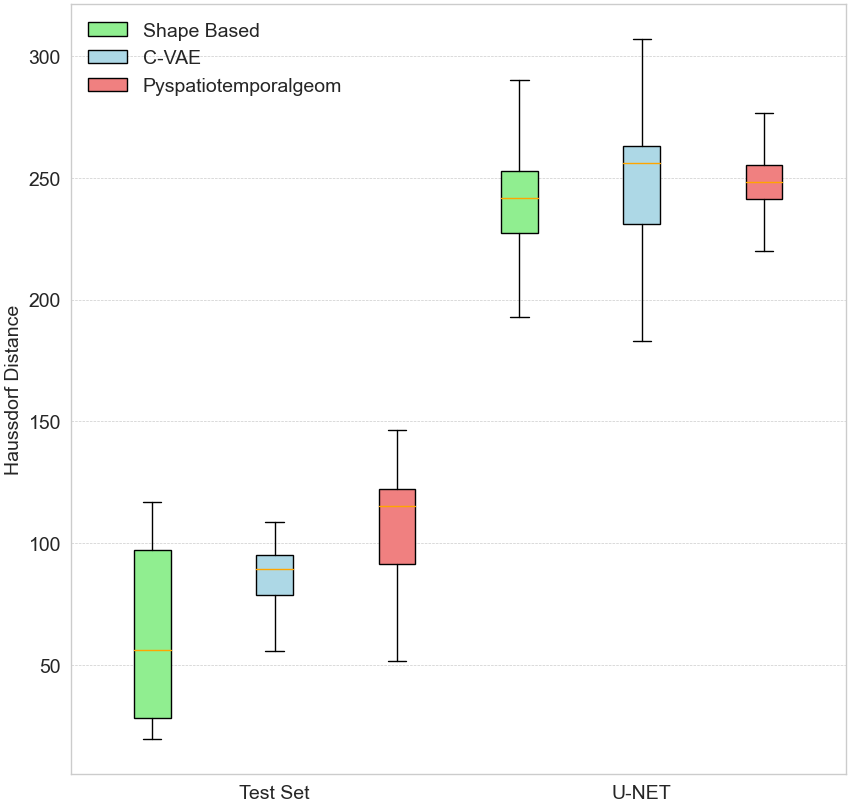

In [264]:
data_ts = [hd_list_shp_ts_sp, hd_list_cvae_ts_sp, hd_list_pstg_ts_sp]
data_pr = [hd_list_shp_pr_sp, hd_list_cvae_pr_sp, hd_list_pstg_pr_sp]

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 10))

# left position of bars on x-axis
left = [0.75, 1.5, 2.25]
# right position of bars on x-axis
right = [3, 3.75, 4.5]

# labels for bars
tick_label = ['Shape Based', 'C-VAE', 'Pyspatiotemporalgeom']

# Create the boxplot with median annotation, showfliers=False, shape based green, cvae blue, pstg red
boxplot_ts = ax.boxplot(data_ts,
                        positions=left,
                        medianprops={'linewidth': 1, 'color': 'orange'},
                        showfliers=False,
                        flierprops=dict(markerfacecolor='r', markersize=2),
                        patch_artist=True)

# Create the boxplot with median annotation, showfliers=False, shape based green, cvae blue, pstg red
boxplot_unet = ax.boxplot(data_pr,
                        positions=right,
                        medianprops={'linewidth': 1, 'color': 'orange'},
                        showfliers=False,
                        flierprops=dict(markerfacecolor='r', markersize=2),
                        patch_artist=True)

colors = ['lightgreen', 'lightblue', 'lightcoral', 'lightgreen', 'lightblue', 'lightcoral']
for patch, color in zip(boxplot_ts['boxes'], colors):
    patch.set_facecolor(color)

for patch, color in zip(boxplot_unet['boxes'], colors):
    patch.set_facecolor(color)

# Add dashed gridlines for y axis ONLY
ax.grid(linestyle='--', linewidth=0.5, axis='y')
# no x gridlines
ax.grid(False, axis='x')

# x labels
ax.set_xticks([1.5, 3.75])
ax.set_xticklabels(['Test Set', 'U-NET'])
# increase4 font size
ax.tick_params(axis='both', which='major', labelsize=14)

# add legend for each model, font size 14
ax.legend([boxplot_ts["boxes"][0], boxplot_ts["boxes"][1], boxplot_ts["boxes"][2]],
            ['Shape Based', 'C-VAE', 'Pyspatiotemporalgeom'], fontsize=14)  
# add y label
ax.set_ylabel('Haussdorf Distance', fontsize=14)

### IoU

In [117]:
# CVAE
model_polys = [loads(wkt) for wkt in cvae_wkt]
iou_list_cvae_dst_ts = list()
print("Calculating IoU...")
for i in range(len(g_t_polys)):
    iou = g_t_polys[i].intersection(model_polys[i]).area / g_t_polys[i].union(model_polys[i]).area
    iou_list_cvae_dst_ts.append(iou)
    
iou_mean_cvae_dst_ts = sum(iou_list_cvae) / len(iou_list_cvae)

Calculating IoU...


In [118]:
# Shape based
model_polys = [loads(wkt) for wkt in shp_wkt]
iou_list_shp_dst_ts = list()
print("Calculating IoU...")
for i in range(len(g_t_polys)):
    iou = g_t_polys[i].intersection(model_polys[i]).area / g_t_polys[i].union(model_polys[i]).area
    iou_list_shp_dst_ts.append(iou)

iou_mean_shp_dst_ts = sum(iou_list_shp) / len(iou_list_shp)

Calculating IoU...


In [119]:
# Pyspatiotemporalgeom
model_polys = [loads(wkt) for wkt in pstg_wkt]
iou_list_pstg_dst_ts = list()
print("Calculating IoU...")
for i in range(len(g_t_polys)):
    iou = g_t_polys[i].intersection(model_polys[i]).area / g_t_polys[i].union(model_polys[i]).area
    iou_list_pstg_dst_ts.append(iou)

iou_mean_pstg_dst_ts = sum(iou_list_pstg) / len(iou_list_pstg)

Calculating IoU...


In [120]:
print(f"Conditional VAE interpolation: mean IoU {iou_mean_cvae_dst_ts:.3f} \n")
print(f"Shape based interpolation: mean IoU {iou_mean_shp_dst_ts:.3f} \n")
print(f"Pyspatiotemporalgeom interpolation: mean IoU {iou_mean_pstg_dst_ts:.3f} \n")

Conditional VAE interpolation: mean IoU 0.910 

Shape based interpolation: mean IoU 0.930 

Pyspatiotemporalgeom interpolation: mean IoU 0.850 



### Boxplots: IoU

Text(0, 0.5, 'Jaccard Index')

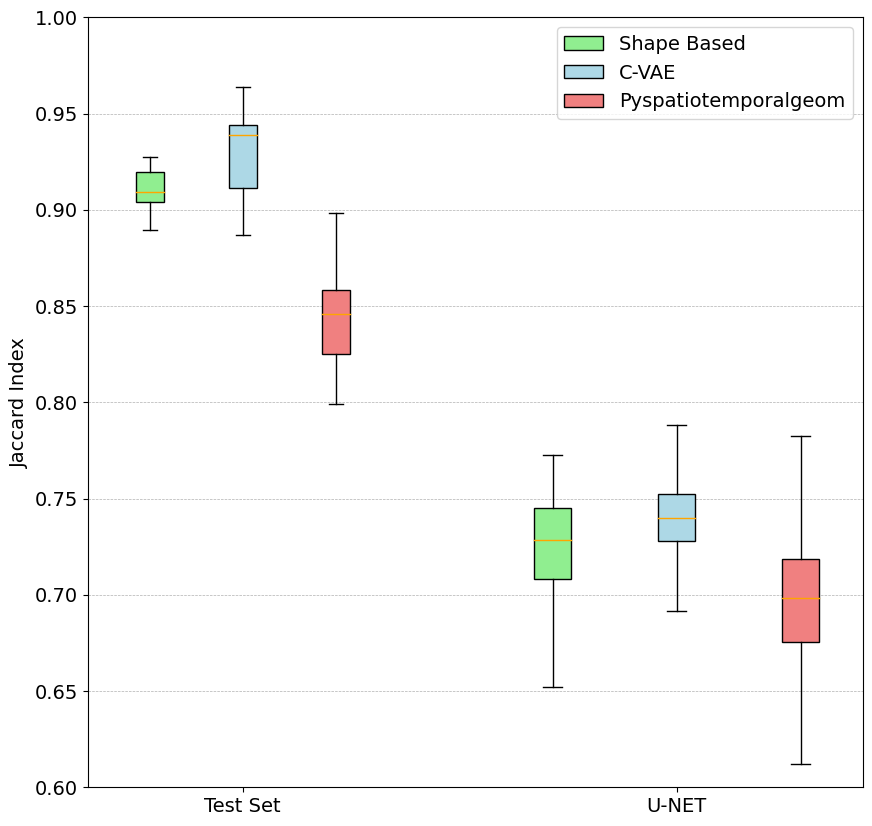

In [121]:
# plot IoU for UNET and test set comparison
# Combine the data into a list
data_ts = [iou_list_cvae_dst_ts, iou_list_shp_dst_ts, iou_list_pstg_dst_ts]
data_unet = [iou_list_cvae_dst, iou_list_shp_dst, iou_list_pstg_dst]

# Set up the figure and axes~
fig, ax = plt.subplots(figsize=(10, 10))


# y-axis from 0 to 1
ax.set_ylim(0.6, 1)

# left position of bars on x-axis
left = [0.75, 1.5, 2.25]
# right position of bars on x-axis
right = [4, 5, 6]
 
# labels for bars
tick_label = ['Shape Based', 'C-VAE', 'Pyspatiotemporalgeom']

# Create the boxplot with median annotation, showfliers=False, shape based green, cvae blue, pstg red
boxplot_ts = ax.boxplot(data_ts,
                        positions=left,
                        medianprops={'linewidth': 1, 'color': 'orange'},
                        showfliers=False,
                        flierprops=dict(markerfacecolor='r', markersize=2),
                        patch_artist=True)

# Create the boxplot with median annotation, showfliers=False, shape based green, cvae blue, pstg red
boxplot_unet = ax.boxplot(data_unet,
                        positions=right,
                        medianprops={'linewidth': 1, 'color': 'orange'},
                        showfliers=False,
                        flierprops=dict(markerfacecolor='r', markersize=2),
                        patch_artist=True)

# Add dashed gridlines ONLY for y-axis
ax.grid(linestyle='--', linewidth=0.5, axis='y')

# x labels


colors = ['lightgreen', 'lightblue', 'lightcoral', 'lightgreen', 'lightblue', 'lightcoral']
for patch, color in zip(boxplot_ts['boxes'], colors):
    patch.set_facecolor(color)

for patch, color in zip(boxplot_unet['boxes'], colors):
    patch.set_facecolor(color)

# Add dashed gridlines for y axis ONLY
ax.grid(linestyle='--', linewidth=0.5, axis='y')

# x labels
ax.set_xticks([1.5, 5])
ax.set_xticklabels(['Test Set', 'U-NET'])
# increase4 font size
ax.tick_params(axis='both', which='major', labelsize=14)

# add legend for each model, font size 14
ax.legend([boxplot_ts["boxes"][0], boxplot_ts["boxes"][1], boxplot_ts["boxes"][2]],
            ['Shape Based', 'C-VAE', 'Pyspatiotemporalgeom'], fontsize=14)  
# add y label
ax.set_ylabel('Jaccard Index', fontsize=14)

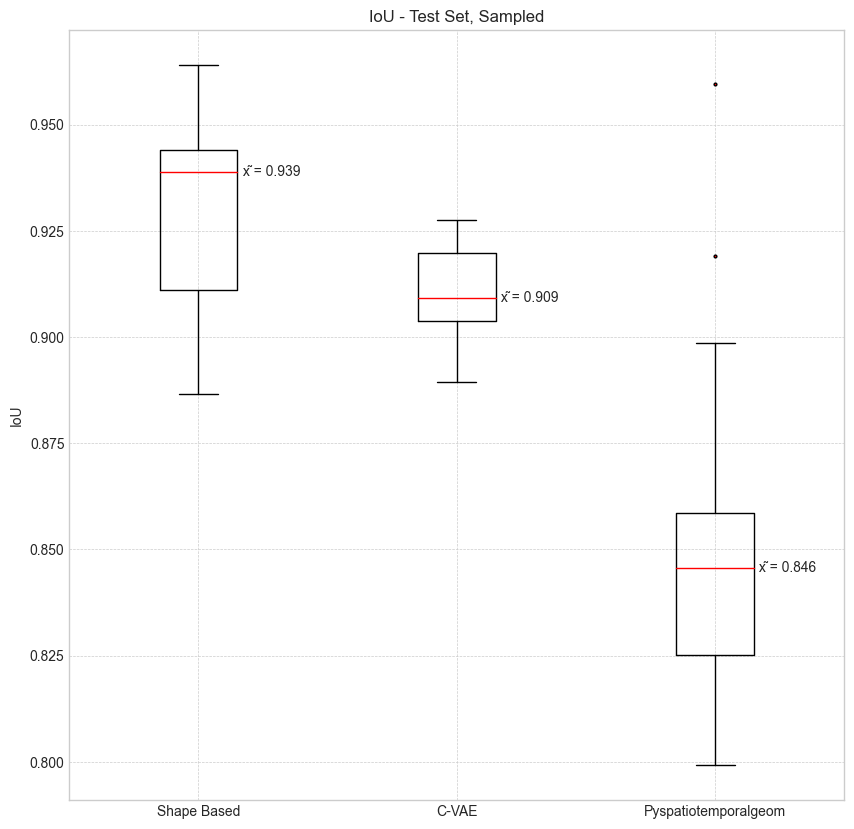

In [212]:
# IoU boxplots in one figure
# Combine the data into a list
data = [iou_list_shp, iou_list_cvae, iou_list_pstg]

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 10))

# Create the boxplot with median annotation
boxplot = ax.boxplot(data, labels=['Shape Based', 'C-VAE', 'Pyspatiotemporalgeom'],
                        medianprops={'linewidth': 1, 'color': 'red'},
                        flierprops=dict(markerfacecolor='r', markersize=2),   
                        patch_artist=False)

# Add dashed gridlines
ax.grid(linestyle='--', linewidth=0.5)

# # Add annotation for median values
for i, box in enumerate(boxplot['medians']):
    ax.annotate(f" x͂ = {box.get_ydata()[0]:.3f}", 
                xy=(i+1, box.get_ydata()[0]), 
                xytext=(29, 0),
                textcoords='offset points',
                va='center')
ax.set_ylabel('IoU')
title = "IoU - Test Set, Sampled"
ax.set_title(title)
plt.show()

In [ ]:
# # Violin plot with tc values for each stride on the same plot and a boxplot including all the values
# fig, ax = plt.subplots(figsize=(20, 5))
# # plots style
# plt.style.use('seaborn-whitegrid')
# # boxplot with all the values
# ax.violinplot([tc_list[i]["tc"] for i in range(0, stride_rng)])
# ax.set_title("Temporal Consistency values for each stride")
# ax.set_xlabel("Stride")
# ax.set_ylabel("Temporal Consistency")
# ax.grid( linestyle="--", alpha=0.5)
# plt.show()

## Temporal Consistency (Distance Sampled Interpolations)

### Exponetial Strided TC

In [229]:
# CVAE
print("Reading WKTs file...")
with open(CVAE_WKT_FILE_SAMPLED, "r") as f:
    model_wkt = f.read().splitlines()

# delete lines with number = idx_sampled (one liner)
model_wkt = [item for i, item in enumerate(model_wkt) if i not in idx_sampled]
num_polygons = len(model_wkt)

# read WKTS file lines and convert to list of shapely polygons
polygons = [loads(wkt) for wkt in model_wkt]
polygons = polygons[:num_polygons]
tc_cvae_list_sp = list()


for str in strides:
    t_c = strided_temporal_consistency(polygons, num_polygons, str)
    print(f"Conditional VAE interpolation: mean TC {t_c['tc_mean']:.4e} with stride {t_c['strd']} \n")
    tc_cvae_list_sp.append(t_c)

Reading WKTs file...
Calculating the temporal consistency with stride 1...
Conditional VAE interpolation: mean TC 9.9980e-01 with stride 1 

Calculating the temporal consistency with stride 10...
Conditional VAE interpolation: mean TC 9.9891e-01 with stride 10 

Calculating the temporal consistency with stride 100...
Conditional VAE interpolation: mean TC 9.9810e-01 with stride 100 

Calculating the temporal consistency with stride 1000...
Conditional VAE interpolation: mean TC 9.9677e-01 with stride 1000 

Calculating the temporal consistency with stride 10000...
Conditional VAE interpolation: mean TC 9.7362e-01 with stride 10000 



In [231]:
# Pyspatiotemporalgeom
print("Reading WKTs file...")
with open(PSTG_WKT_FILE_SAMPLED, "r") as f:
    model_wkt = f.read().splitlines()

# delete lines with number = idx_sampled (one liner)
model_wkt = [item for i, item in enumerate(model_wkt) if i not in idx_sampled]
num_polygons = len(model_wkt)

# read WKTS file lines and convert to list of shapely polygons
polygons = [loads(wkt) for wkt in model_wkt]
polygons = polygons[:num_polygons]
tc_pstG_list_sp = list()

for str in strides:
    t_c = strided_temporal_consistency(polygons, num_polygons, str)
    print(f"Pyspatiotemporalgeom interpolation: mean TC {t_c['tc_mean']:.4e} with stride {t_c['strd']} \n")
    tc_pstG_list_sp.append(t_c)

Reading WKTs file...
Calculating the temporal consistency with stride 1...
Pyspatiotemporalgeom interpolation: mean TC 9.9743e-01 with stride 1 

Calculating the temporal consistency with stride 10...
Pyspatiotemporalgeom interpolation: mean TC 9.7548e-01 with stride 10 

Calculating the temporal consistency with stride 100...
Pyspatiotemporalgeom interpolation: mean TC 8.2962e-01 with stride 100 

Calculating the temporal consistency with stride 1000...
Pyspatiotemporalgeom interpolation: mean TC 6.3678e-01 with stride 1000 

Calculating the temporal consistency with stride 10000...
Pyspatiotemporalgeom interpolation: mean TC 9.0217e-01 with stride 10000 



In [230]:
# Shape based
print("Reading WKTs file...")
with open(SHP_WKT_FILE_SAMPLED, "r") as f:
    model_wkt = f.read().splitlines()

# delete lines with number = idx_sampled (one liner)
model_wkt = [item for i, item in enumerate(model_wkt) if i not in idx_sampled]
num_polygons = len(model_wkt)

# read WKTS file lines and convert to list of shapely polygons
polygons = [loads(wkt) for wkt in model_wkt]
polygons = polygons[:num_polygons]
tc_shp_list_sp = list()

for str in strides:
    t_c = strided_temporal_consistency(polygons, num_polygons, str)
    print(f"Shape based interpolation: mean TC {t_c['tc_mean']:.4e} with stride {t_c['strd']} \n")
    tc_shp_list_sp.append(t_c)

Reading WKTs file...
Calculating the temporal consistency with stride 1...
Shape based interpolation: mean TC 9.9980e-01 with stride 1 

Calculating the temporal consistency with stride 10...
Shape based interpolation: mean TC 9.9802e-01 with stride 10 

Calculating the temporal consistency with stride 100...
Shape based interpolation: mean TC 9.8046e-01 with stride 100 

Calculating the temporal consistency with stride 1000...
Shape based interpolation: mean TC 8.5150e-01 with stride 1000 

Calculating the temporal consistency with stride 10000...
Shape based interpolation: mean TC 8.5818e-01 with stride 10000 



In [233]:
print(f"Conditional VAE interpolation: mean TC {sum([tc['tc_mean'] for tc in tc_cvae_list_sp])/len(tc_cvae_list_sp):.4e} \n")
print(f"Shape based interpolation: mean TC {sum([tc['tc_mean'] for tc in tc_shp_list_sp])/len(tc_shp_list_sp):.4e} \n")   
print(f"Pyspatiotemporalgeom interpolation: mean TC {sum([tc['tc_mean'] for tc in tc_pstG_list_sp])/len(tc_pstG_list_sp):.4e} \n")

Conditional VAE interpolation: mean TC 9.9344e-01 

Shape based interpolation: mean TC 9.3759e-01 

Pyspatiotemporalgeom interpolation: mean TC 8.6829e-01 



### Boxplots: Temporal Consistency (Distance Sampled)

Text(0.5, 0, 'Stride')

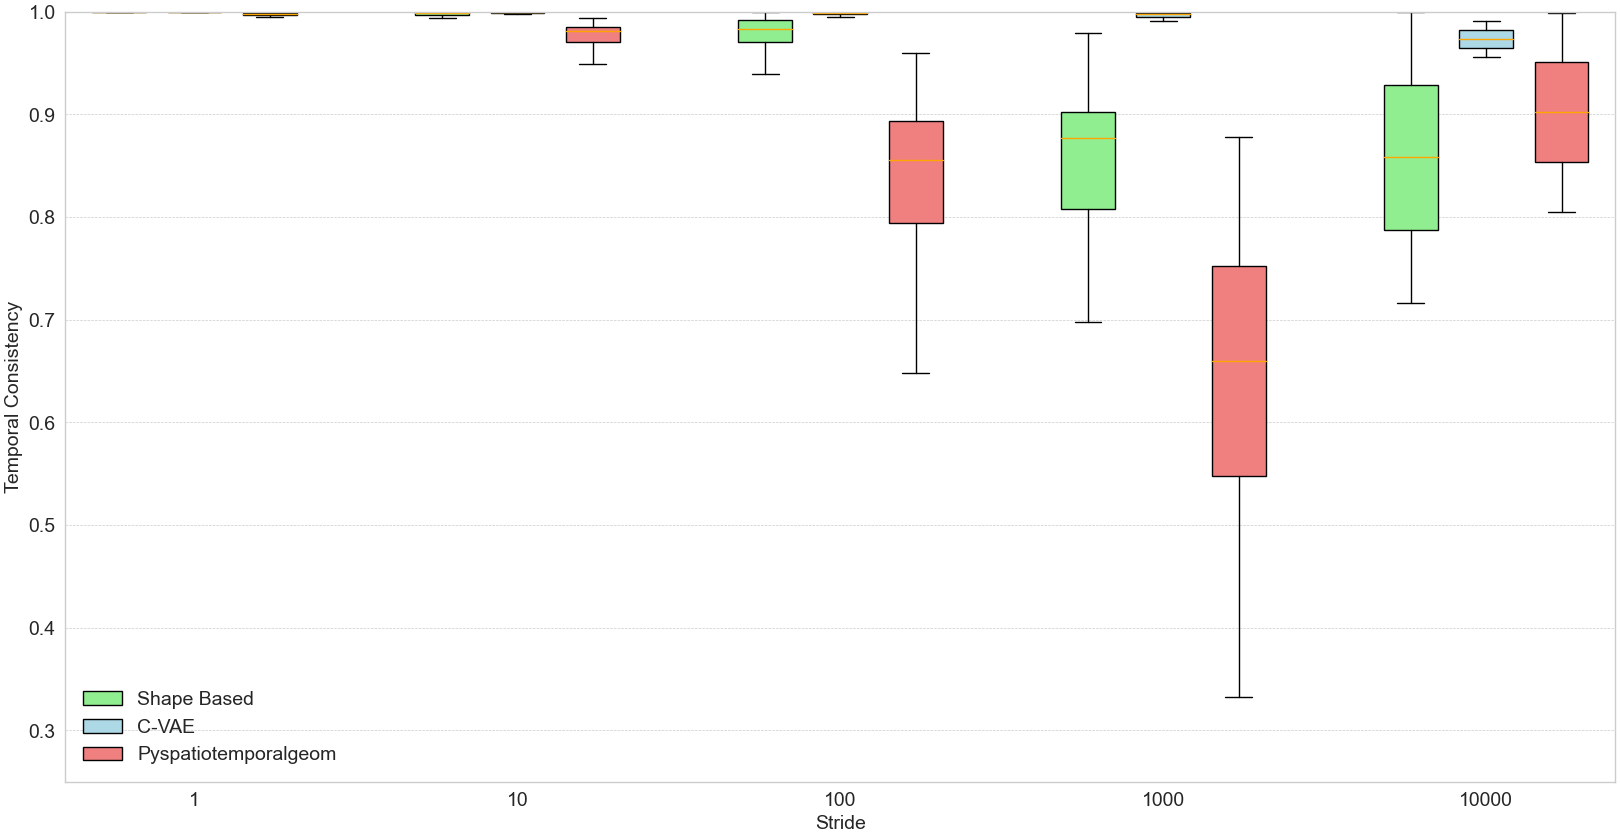

In [237]:
# combine the data into a list and orders it according to the stide values
data = [tc_shp_list_sp[0]['tc'], tc_cvae_list_sp[0]['tc'], tc_pstG_list_sp[0]['tc'],
        tc_shp_list_sp[1]['tc'], tc_cvae_list_sp[1]['tc'], tc_pstG_list_sp[1]['tc'],
        tc_shp_list_sp[2]['tc'], tc_cvae_list_sp[2]['tc'], tc_pstG_list_sp[2]['tc'],
        tc_shp_list_sp[3]['tc'], tc_cvae_list_sp[3]['tc'], tc_pstG_list_sp[3]['tc'],
        tc_shp_list_sp[4]['tc'], tc_cvae_list_sp[4]['tc'], tc_pstG_list_sp[4]['tc']]


        
# Set up the figure and axes
fig, ax = plt.subplots(figsize=(20, 10))

# y-axis from 0 to 1
ax.set_ylim(0.25, 1)

# positions of the boxplots
pos = [1.3, 2, 2.7, 4.3, 5, 5.7, 7.3, 8, 8.7, 10.3, 11, 11.7, 13.3, 14, 14.7]

# Create the boxplot with median annotation, showfliers=False, shape based green, cvae blue, pstg red
boxplot = ax.boxplot(data,
                        positions=pos,
                        medianprops={'linewidth': 1, 'color': 'orange'},
                        showfliers=False,
                        flierprops=dict(markerfacecolor='r', markersize=2),
                        patch_artist=True)

colors = ['lightgreen', 'lightblue', 'lightcoral'] *5

for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)

ax.set_xticks([2, 5, 8, 11, 14]);
ax.set_xticklabels(['1', '10', '100', '1000', '10000']);

# Add dashed gridlines for y axis ONLY
ax.grid(linestyle='--', linewidth=0.5, axis='y')
ax.grid(False, axis='x')

# increase4 font size
ax.tick_params(axis='both', which='major', labelsize=14)

# add legend for each model, font size 14
ax.legend([boxplot["boxes"][0], boxplot["boxes"][1], boxplot["boxes"][2]],
            ['Shape Based', 'C-VAE', 'Pyspatiotemporalgeom'], fontsize=14, loc = 'lower left')
# add y label
ax.set_ylabel('Temporal Consistency', fontsize=14)

# add x label
ax.set_xlabel('Stride', fontsize=14)

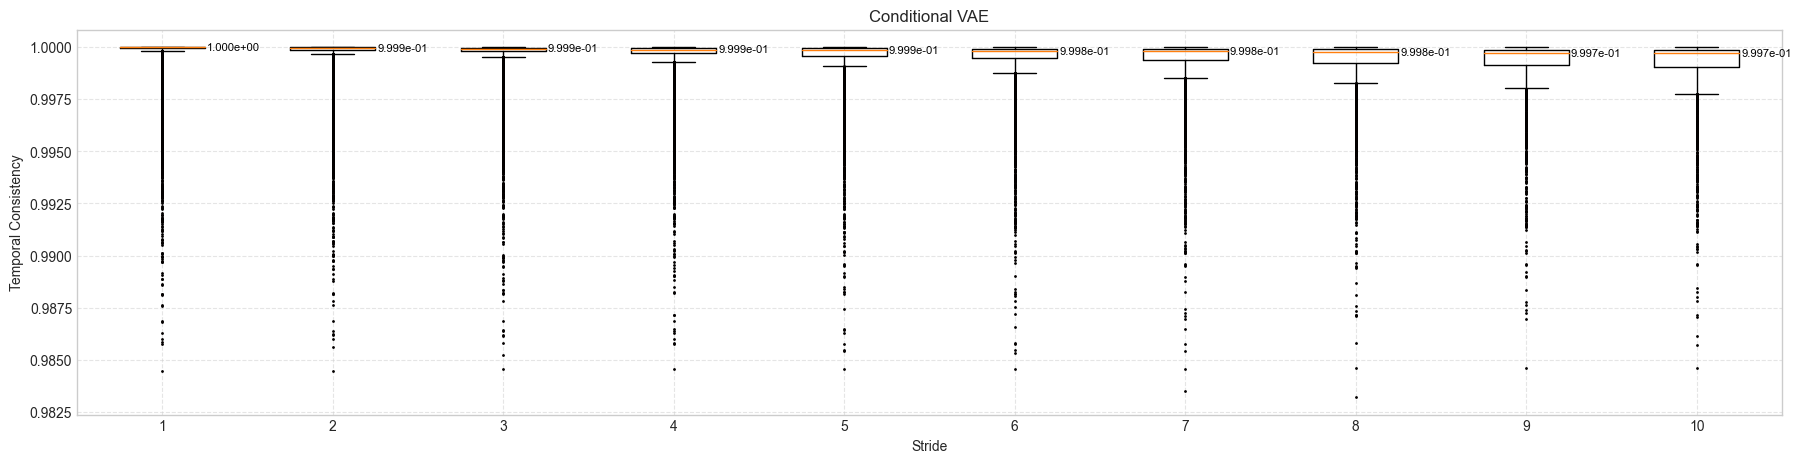

In [217]:
# CVAE boxplots in a single figure
fig, ax = plt.subplots(figsize=(22, 5))

ax.set_title('Conditional VAE')
ax.boxplot([tc_cvae_list[i]["tc"] for i in range(0, stride_rng)], 
           flierprops=dict(markerfacecolor='r', markersize=1))   

ax.set_xlabel("Stride")
ax.set_ylabel("Temporal Consistency")

# add annotations with the median value
for i in range(0, stride_rng):
    ax.annotate(f"{np.median(tc_cvae_list[i]['tc']):.3e}", (i+1, 
                np.median(tc_cvae_list[i]['tc'])), ha='left', va='center', 
                size=8, color='black', xytext=(32, 0), 
                textcoords='offset points')
    

ax.grid( linestyle="--", alpha=0.5)
plt.show()

(0.0, 6.283185307179586)

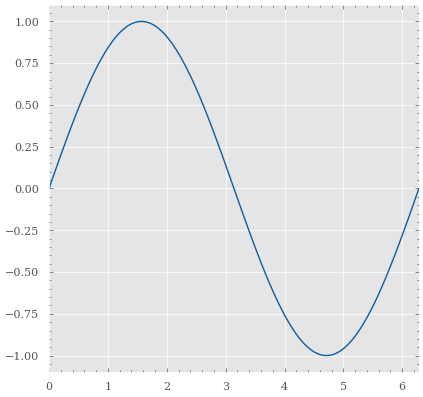

In [129]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots


# Using seaborn's style

width = 345

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}

# plt.rcParams.update(tex_fonts)

x = np.linspace(0, 2*np.pi, 100)
# Initialise figure instance
fig, ax = plt.subplots(1, 1, figsize=(width/72.27, width/72.27))
# Plot
ax.plot(x, np.sin(x))
ax.set_xlim(0, 2 * np.pi)
# ax.set_xlabel(r'$\theta$')
# ax.set_ylabel(r'$\sin (\theta)$')

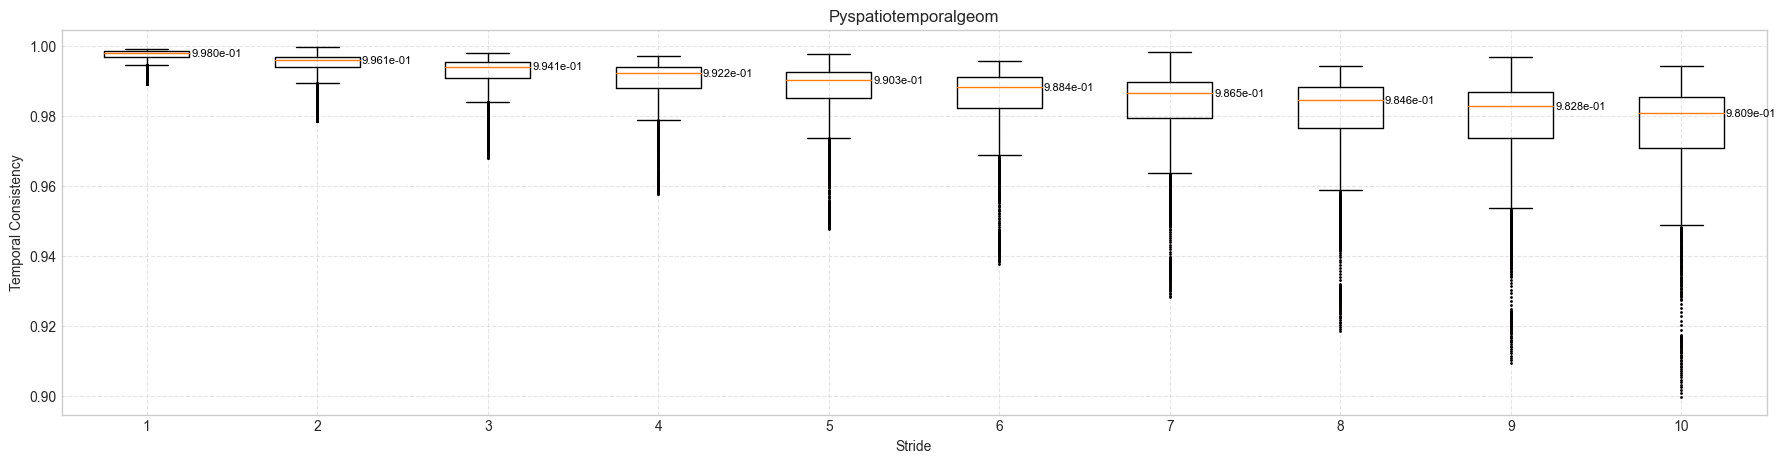

In [221]:
# Pyspatiotemporalgeom boxplots in a single figure
fig, ax = plt.subplots(figsize=(22, 5))

ax.set_title('Pyspatiotemporalgeom')
ax.boxplot([tc_pstG_list[i]["tc"] for i in range(0, stride_rng)],
              flierprops=dict(markerfacecolor='r', markersize=1))
ax.set_xlabel("Stride")
ax.set_ylabel("Temporal Consistency")

# add annotations with the median value
for i in range(0, stride_rng):
    ax.annotate(f"{np.median(tc_pstG_list[i]['tc']):.3e}", (i+1, 
                np.median(tc_pstG_list[i]['tc'])), ha='left', va='center', 
                size=8, color='black', xytext=(32, 0), 
                textcoords='offset points')

ax.grid( linestyle="--", alpha=0.5)
plt.show()

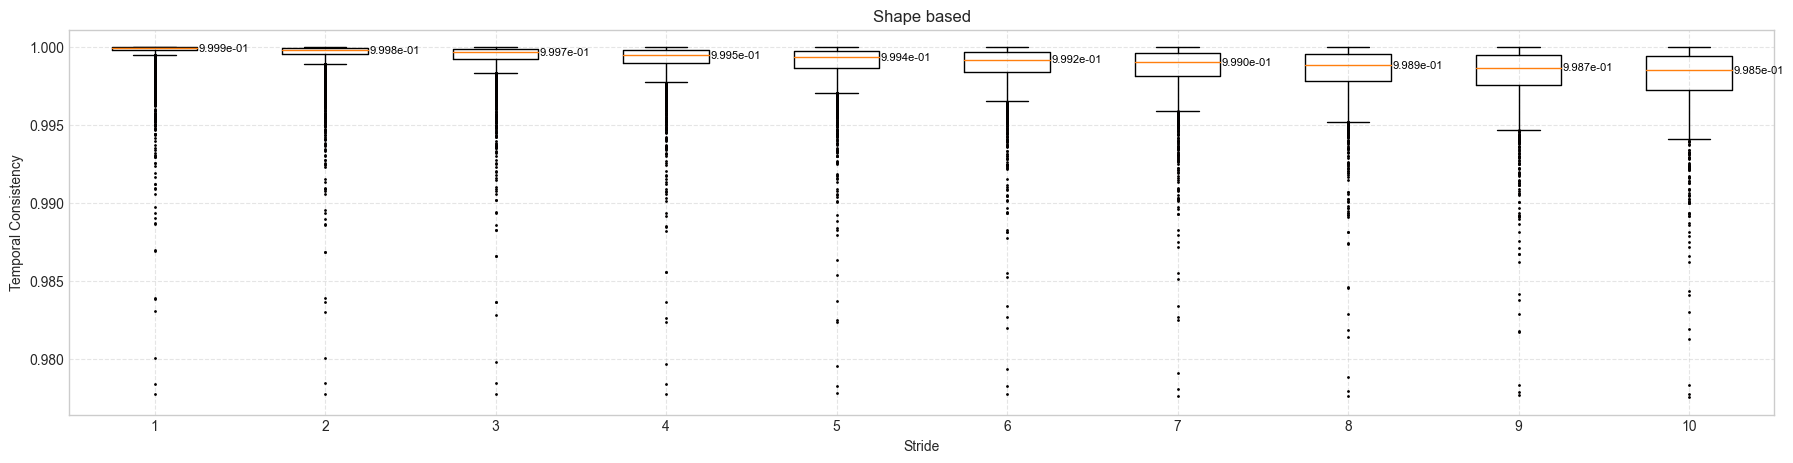

In [219]:
# SHP boxplots in a single figure
fig, ax = plt.subplots(figsize=(22, 5))

ax.set_title('Shape based')
ax.boxplot([tc_shp_list[i]["tc"] for i in range(0, stride_rng)],
                flierprops=dict(markerfacecolor='r', markersize=1))
ax.set_xlabel("Stride")
ax.set_ylabel("Temporal Consistency")

# add annotations with the median value
for i in range(0, stride_rng):
    ax.annotate(f"{np.median(tc_shp_list[i]['tc']):.3e}", (i+1, 
                np.median(tc_shp_list[i]['tc'])), ha='left', va='center', 
                size=8, color='black', xytext=(32, 0), 
                textcoords='offset points')

ax.grid( linestyle="--", alpha=0.5)
plt.show()

#### (Work in Progress..) Graph Based Evaluation 

In [ ]:
import networkx as nx
from shapely.geometry import Polygon
import numpy as np

def compute_graph_consistency(frames_polygons, frames_masks, threshold=0.5):
    """
    Compute temporal consistency between frames using a graph-based approach.
    
    Parameters:
        frames_polygons (list): List of Shapely polygons representing the burned area for each frame.
        frames_masks (list): List of binary masks representing the burned area for each frame.
        threshold (float): Threshold value for considering a pixel as burned or unburned.
        
    Returns:
        float: Temporal consistency score between 0 and 1.
    """
    # Define a function to compute the intersection over union (IoU) between two polygons
    def compute_iou(poly1, poly2):
        intersection = poly1.intersection(poly2).area
        union = poly1.union(poly2).area
        return intersection / union
    
    # Build a graph for each frame using the polygon centroids as nodes
    graphs = []
    for polygons in frames_polygons:
        graph = nx.Graph()
        centroids = [poly.centroid for poly in polygons]
        for i, centroid1 in enumerate(centroids):
            for j, centroid2 in enumerate(centroids):
                if i != j:
                    poly1 = polygons[i]
                    poly2 = polygons[j]
                    iou = compute_iou(poly1, poly2)
                    if iou > 0:
                        graph.add_edge(i, j, weight=iou)
        graphs.append(graph)
    
    # Compute the temporal consistency score
    scores = []
    for i in range(len(graphs)-1):
        graph1 = graphs[i]
        graph2 = graphs[i+1]
        intersection = 0
        union = 0
        for node in graph1.nodes:
            poly1 = frames_polygons[i][node]
            mask1 = frames_masks[i][:,:,0]
            mask1 = np.where(mask1 > threshold, 1, 0)
            for neighbor in graph1.neighbors(node):
                poly2 = frames_polygons[i][neighbor]
                mask2 = frames_masks[i][:,:,0]
                mask2 = np.where(mask2 > threshold, 1, 0)
                if graph2.has_edge(node, neighbor):
                    poly3 = frames_polygons[i+1][node]
                    mask3 = frames_masks[i+1][:,:,0]
                    mask3 = np.where(mask3 > threshold, 1, 0)
                    intersection += np.sum(np.logical_and(mask1, mask3)) + np.sum(np.logical_and(mask2, mask3))
                    union += np.sum(np.logical_or(mask1, mask2)) + np.sum(mask3)
        score = intersection / union if union > 0 else 1.0
        scores.append(score)
    
    # Return the average temporal consistency score
    return np.mean(scores)